# This experiment/notebook is to analyze experiment SD613 - live imaging of Nwk-HALO and BRP-mimic

## Outline

# Imports, load data, set options

In [20]:
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import os
import Aggregate_PAZ_Data as agg
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import hmean
from sklearn.neighbors import KernelDensity as kde
from sklearn.model_selection import GridSearchCV
from scipy.stats import kstest, kruskal, f_oneway as anova
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import scikit_posthocs as ph
import importlib
import libpysal
import pointpats as pp
import CentroidAnalysis as ca
import tifffile as tf

In [24]:
# Basic info about experiment
version_num = "218"
experiment_num = "Example"
root_dir = "C:\\Users\\rodallab\\Desktop\\PAZ_Example Data\\MultiDescriptive\\"
savepath = f"C:\\Users\\rodallab\\Desktop\\PAZ_Example Data\\ExampleMultiCompiled\\"
statspath = os.path.join(savepath, "Stats")

data_order = ["DYN", "NWK", "FASII"]
if not os.path.isdir(savepath):
    os.mkdir(savepath)

if not os.path.isdir(statspath):
    os.mkdir(statspath)
# Set graphing style and options
ax_params = {"axes.spines.right": False, "axes.spines.top": False, "figure.dpi": 300, "savefig.dpi":300}
sns.set_theme(style="ticks", rc=ax_params)
sns.set_context('paper', font_scale=2)
c_palette="muted"
sns.set_palette(c_palette)




## Load raw data into dataframes

In [25]:
# Load composite mesh based PAZ data
CompMesh = agg.aggregate_csvs(root_dir, version_num, "Comp_ALLTHECELLS.csv")



In [26]:
# This is what the dataframe looks like
CompMesh

,Experiment,Image,AZcount,AZidtotal,AZareatotal,Area,Circ.,EDMmin,EDMmean,CoreArea,...,CoreCoV_DAP160,CoreLoGrms_DAP160,MeshMean_DAP160,MeshCoV_DAP160,MeshLoGrms_DAP160,MeshRatio_DAP160,EntrD2_DAP160,EntrD4_DAP160,EntrD6_DAP160,EntrD8_DAP160
0,EX555,SD555_5mm_L1_m4_2020_12_06__09_42_45_Out-1_Max...,2.0,0.28422,0.14354,0.41602,0.41636,0.0,3.68421,0.07542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EX555,SD555_5mm_L1_m4_2020_12_06__09_42_45_Out-1_Max...,2.0,0.16091,0.09488,0.61309,0.50287,6.0,12.67460,0.27248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EX555,SD555_5mm_L1_m4_2020_12_06__09_42_45_Out-1_Max...,2.0,0.25354,0.18490,0.42819,0.73460,1.0,4.06250,0.15570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EX555,SD555_5mm_L1_m4_2020_12_06__09_42_45_Out-1_Max...,1.0,0.02870,0.02919,0.21409,0.90947,1.0,4.80682,0.04136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX555,SD555_5mm_L1_m4_2020_12_06__09_42_45_Out-1_Max...,2.0,0.12114,0.08758,0.38196,0.82608,6.0,14.14650,0.14111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,EX603,SD603_L06_m4__2021_11_24__14_06_17_Out-1_MaxZ1...,1.0,0.07854,0.09799,0.40284,0.72712,1.0,6.53153,0.17057,...,0.57898,1.00660,1.36953,0.29514,1.64919,2.11584,5.3272,5.3810,5.4228,5.3989
819,EX603,SD603_L06_m4__2021_11_24__14_06_17_Out-1_MaxZ1...,1.0,0.04405,0.03992,0.02903,0.95824,11.0,13.43750,0.00544,...,0.00536,0.77056,1.29921,0.17205,1.03302,0.99350,3.7842,3.7842,3.7527,3.7842
820,EX603,SD603_L06_m4__2021_11_24__14_06_17_Out-1_MaxZ1...,1.0,0.10020,0.09617,0.13972,0.66862,0.0,2.38961,0.01815,...,0.25298,0.92871,1.17759,0.31351,1.71049,1.76872,4.9506,4.9121,4.9313,4.8832
821,EX603,SD603_L06_m4__2021_11_24__14_06_17_Out-1_MaxZ1...,0.0,0.00000,0.00000,0.07440,0.82630,3.0,6.63415,0.00181,...,0.00000,0.37730,1.41641,0.08353,0.95646,1.29444,4.2449,4.3828,4.3671,4.2253


In [15]:
# Load composite mesh based PAZ data
CompMesh = pd.read_csv(os.path.join(root_dir, "Comp_ALLTHECELLS.csv"))
CompMesh["Experiment"]=experiment_num


#CompMesh["geno"] = CompMesh.loc[:, 'Image'].str.slice(6, 10)

# Load BRP based 'PAZ' data 
AZMesh = pd.read_csv(os.path.join(root_dir, "BRP_ALLTHECELLS.csv"))
AZMesh["Experiment"]="SD622"
AZMesh["geno"] = AZMesh.loc[:, 'Image'].str.slice(6, 10)

# Add new column to mesh datasets to denote NMJs instead of images
CompMesh['nmjid'] = CompMesh['Image'].str.split("Out-", expand=True)[0]
AZMesh['nmjid'] = AZMesh['Image'].str.split("Out-", expand=True)[0]

# Filter out all mesh units with mean EDM <=7.5
CompMeshF = CompMesh.loc[CompMesh.EDMmean>=7.5, :]
AZMeshF = AZMesh.loc[AZMesh.EDMmean>=7.5, :]

# Filter out mesh units without AZ
CompMeshF_AZ = CompMeshF.loc[CompMeshF.AZcount>0, :]

Composite_1AZ=CompMesh[CompMesh.AZcount==1]


# Load whole NMJ data
wholeNMJ = pd.read_csv(os.path.join(root_dir, "NMJ_Data.csv"))


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\rodallab\\Desktop\\PAZ_Example Data\\SingleDescriptive\\SDxxx\\Comp_ALLTHECELLS.csv'

## Coloc analyses

In [13]:
# Whole NMJ coloc
wholeNMJ["Experiment"]=experiment_num
wholeNMJ.rename(columns={"File":"Image"})
#nmjpcc=agg.subset_data(wholeNMJ, ["geno", "PCC"])
wholeNMJ

,NMJ_Area,StdDev_DYN,logrms_DYN,StdDev_BRP,logrms_BRP,StdDev_NWK,logrms_NWK,PCC_DYN-BRP,PCC_DYN-NWK,PCC_BRP-NWK,...,Jaccard_DYN-NWK,HexE_DYN-Composite,Jaccard_DYN-Composite,HexE_BRP-NWK,Jaccard_BRP-NWK,HexE_BRP-Composite,Jaccard_BRP-Composite,HexE_NWK-Composite,Jaccard_NWK-Composite,Experiment
0,23.78628,0.42742,0.95769,1.25865,3.58564,0.52850,1.32890,-0.11901,0.49849,-0.08424,...,0.56995,30.35076,0.56029,18.31938,0.44052,41.63143,0.62289,23.06047,0.52099,Example
1,12.81399,0.41128,1.20204,1.20808,3.64971,0.65496,1.84354,-0.09055,0.52791,-0.14517,...,0.56770,31.25214,0.60183,39.61678,0.53541,46.72830,0.63207,35.47841,0.61178,Example
2,16.86717,0.43759,0.95317,1.06044,2.95683,0.53285,1.36320,-0.13469,0.55862,-0.18367,...,0.58350,23.95750,0.58615,32.05332,0.52709,43.55945,0.66017,33.88912,0.58945,Example
3,9.88723,0.48439,1.15485,1.26649,3.95414,0.56303,1.54983,-0.05505,0.55101,-0.13743,...,0.66044,30.92299,0.63093,21.72721,0.53905,24.14901,0.61285,38.41745,0.65003,Example
4,7.28405,0.51815,1.16950,1.19892,3.80133,0.60316,1.78024,-0.00632,0.39208,0.01749,...,0.57529,28.10235,0.53099,27.92040,0.55019,52.28715,0.74881,31.83872,0.57674,Example
5,12.22766,0.53429,1.23215,1.18779,3.62531,0.69950,1.93362,-0.05295,0.49347,-0.06156,...,0.63253,33.41337,0.58011,27.19176,0.49309,44.29622,0.68000,31.47863,0.54993,Example


In [5]:
meshPCCs = agg.subset_data(CompMeshF_AZ, ["geno", "MeshPCC"], "BRP")
ImgMean=meshPCCs.groupby(["Image", "geno"]).mean().reset_index()
ImgMean

,Image,geno,MeshPCC:DYN-NWK
0,SD555_5mm_L1_m4_2020_12_06__09_42_45_Out-1_Max...,5mm_,0.483690
1,SD555_5mm_L2__2020_12_06__10_15_39_Out-1_MaxZ8...,5mm_,0.300504
2,SD555_5mm_L3__2020_12_06__10_42_15_Out-1_MaxZ7...,5mm_,0.521597
3,SD555_5mm_L3__2020_12_06__10_55_22_Out-1_MaxZ8...,5mm_,0.320785
4,SD555_5mm_L4__2020_12_06__13_28_14_Out-1_MaxZ7...,5mm_,0.257702
5,SD555_5mm_L4__2020_12_06__13_44_30_Out-1_MaxZ9...,5mm_,0.433738


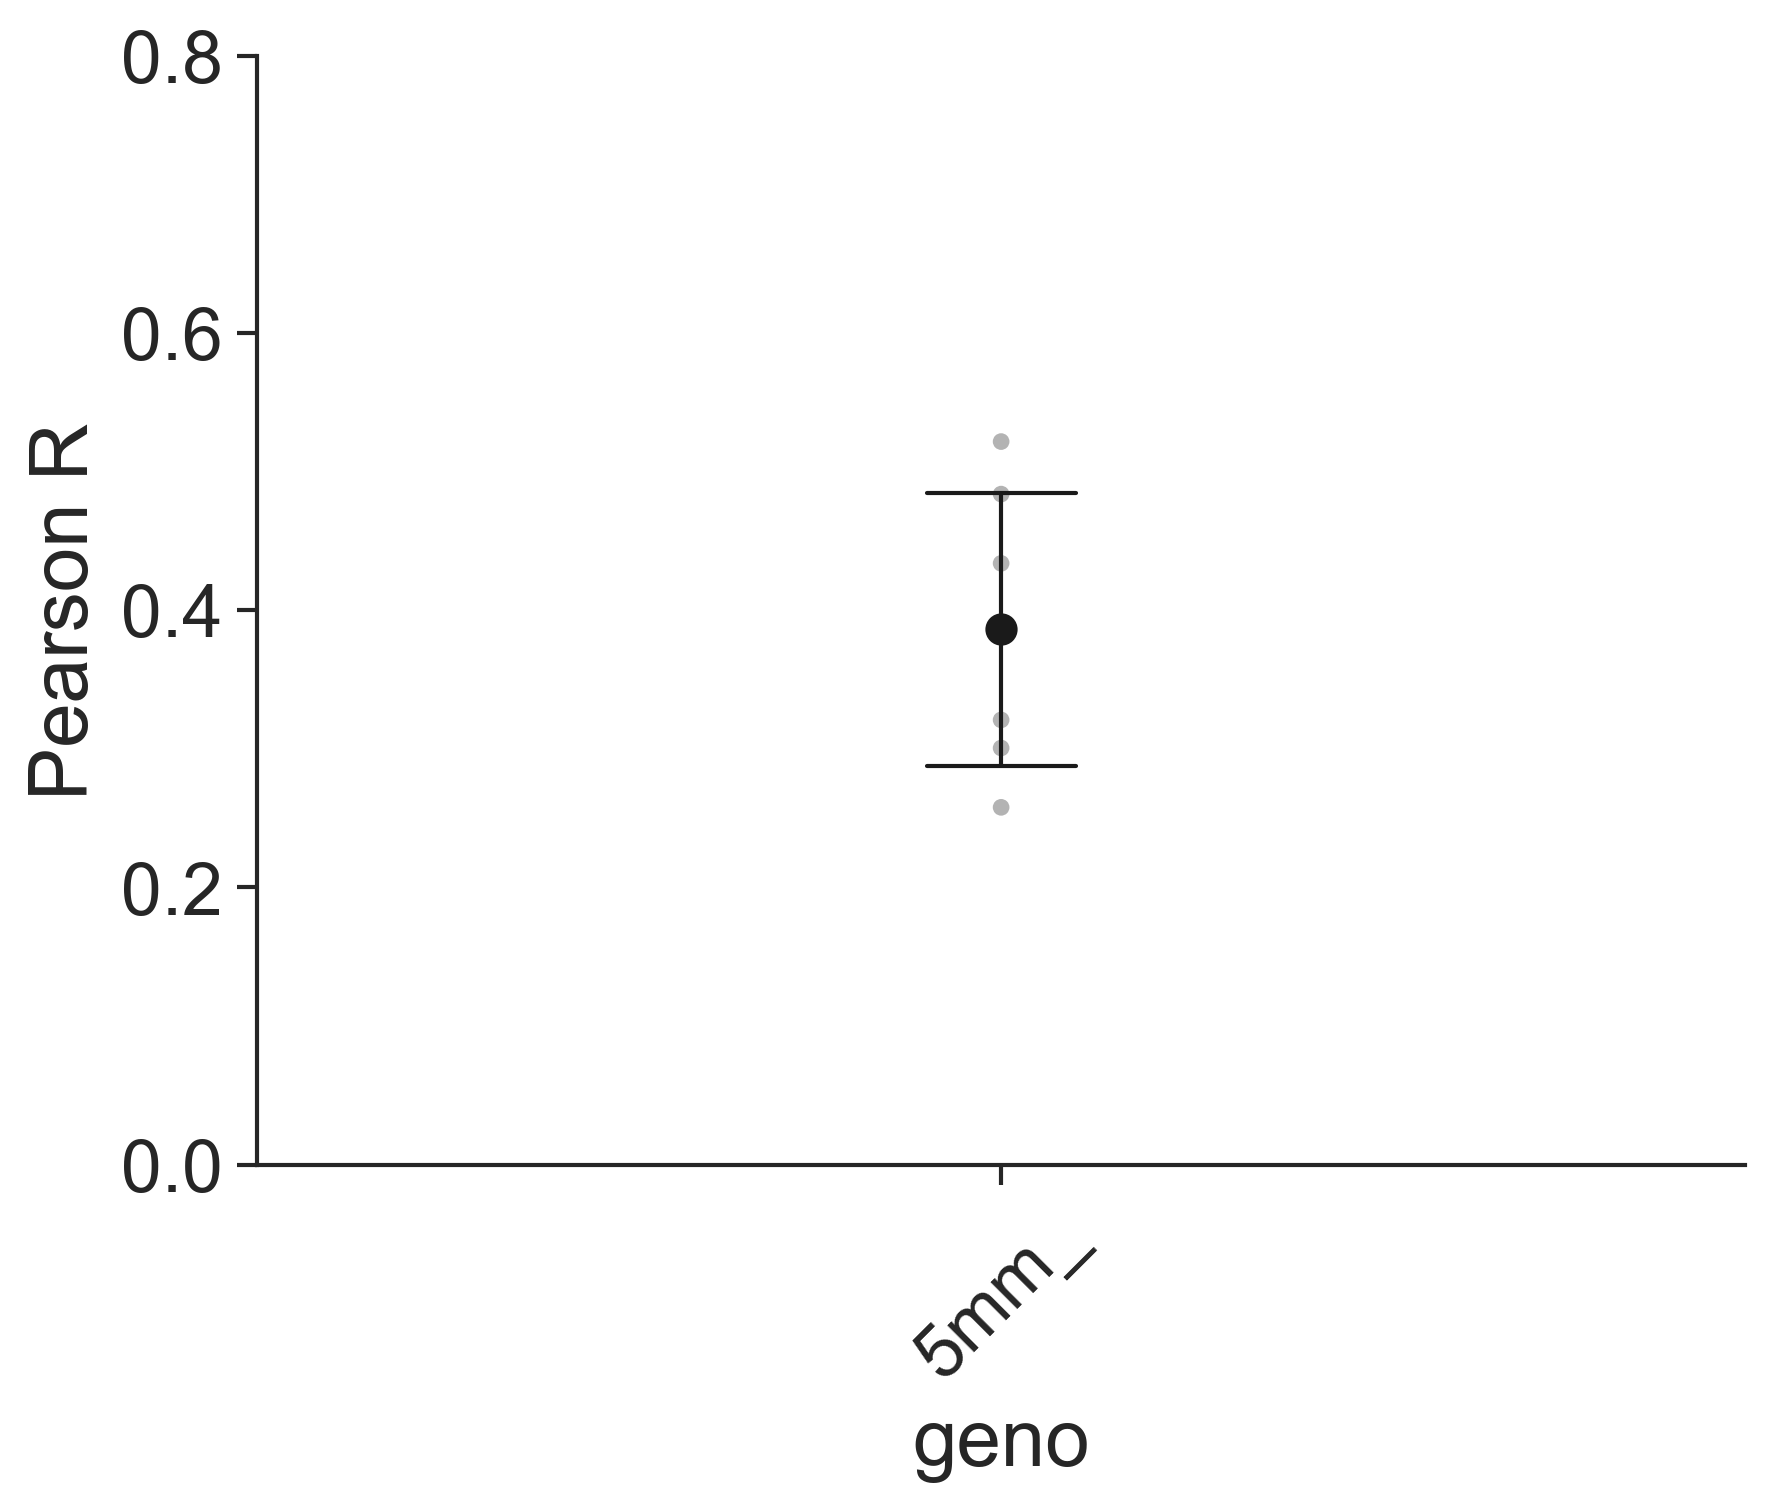

In [6]:
FIG = "SD622_MeshPCC"
# Manually define custom order to display pairwise PCC values
pcc_order = ["NWK-DYN"]
pcc_order = [f"MeshPCC:{i}" for i in pcc_order]

# Subset out meshPCC measures
meshPCCs = agg.subset_data(CompMeshF_AZ, ["geno", "MeshPCC"], "BRP")
ImgMean=meshPCCs.groupby(["Image", "geno"]).mean().reset_index()
ImgMean=ImgMean.drop(["Image"], axis=1).melt(id_vars="geno", value_name="Pearson R")


# Plot
sp = sns.swarmplot(data=ImgMean, x="geno", y="Pearson R", 
                   size=4, palette=['0.7'], zorder=0)
#sns.swarmplot(data=ExpMean, x="variable", y="Pearson R", hue="Experiment", size=8, 
#             edgecolor="k", linewidth=1, zorder=0, ax=sp)

sns.pointplot(data=ImgMean, x="geno", y="Pearson R",
              ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, ax=sp)

plt.ylim((0,0.8))
plt.xticks(rotation=45)
plt.savefig(os.path.join(savepath, FIG+".svg"))
None

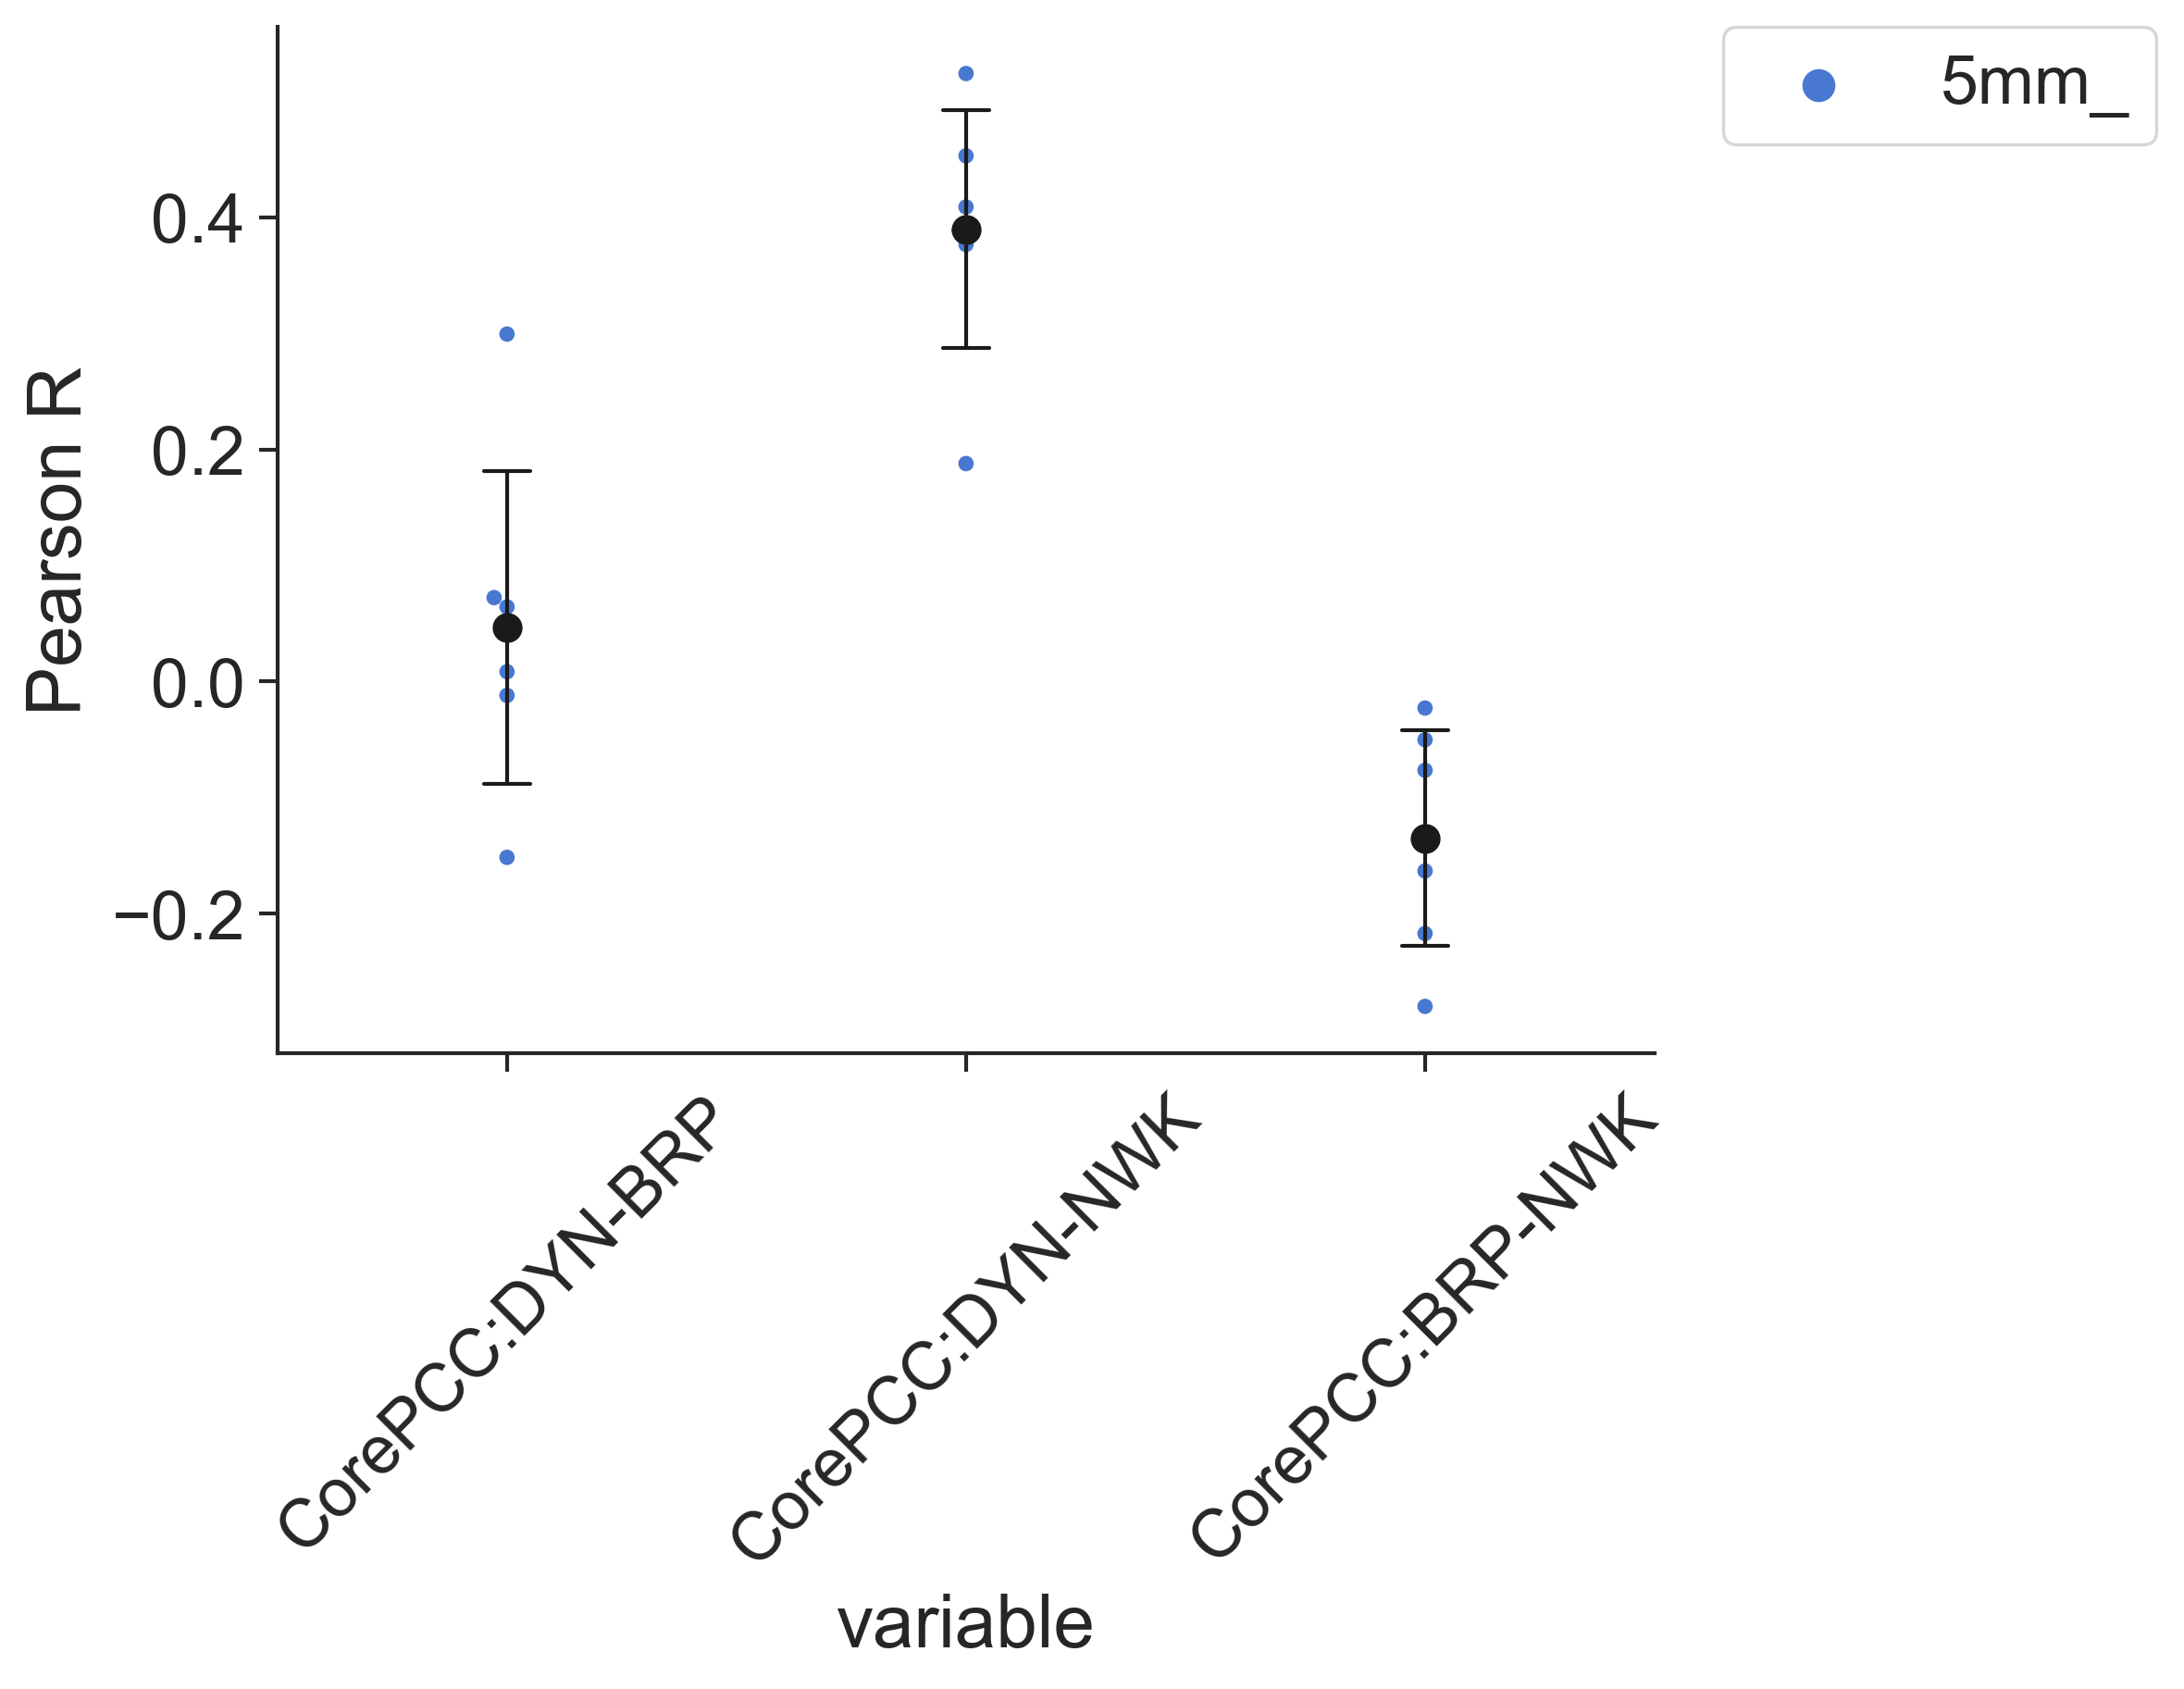

In [7]:
FIG = "SD622_CorePCC"
# Manually define custom order to display pairwise PCC values
pcc_order = ["NWK-BRP", "DYN-BRP"]
pcc_order = [f"CorePCC:{i}" for i in pcc_order]

# Subset out meshPCC measures
meshPCCs = agg.subset_data(CompMeshF_AZ, ["geno", "CorePCC"])
ImgMean=meshPCCs.groupby(["Image", "geno"]).mean().reset_index()
ImgMean=ImgMean.melt(id_vars=["Image", "geno"], value_name="Pearson R")


# Plot
sp = sns.swarmplot(data=ImgMean, x="variable", y="Pearson R", 
                   size=4, hue="geno", dodge=True, zorder=0)
#sns.swarmplot(data=ExpMean, x="variable", y="Pearson R", hue="Experiment", size=8, 
#             edgecolor="k", linewidth=1, zorder=0, ax=sp)

sns.pointplot(data=ImgMean, x="variable", y="Pearson R",
              ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, hue="geno", dodge=0.55, ax=sp)


plt.xticks(rotation=45)
handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(savepath, FIG+".svg"))
None

## Fig 2D Mesh Ratio

In [17]:
# Subset mesh ratio data and pair normalize by channel

compRatio = agg.subset_data(CompMeshF_AZ, ["geno", "Ratio"])
compRatio = compRatio.rename(columns = {"value":"Norm. MeshRatio"})
compRatio

,Experiment,Image,MeshRatio_NWK,MeshRatio_DYN,MeshRatio_BRP,geno
6,SD622,SD622_cont_L01_m4__2022_06_10__17_03_07-Airysc...,1.63571,2.13984,0.84588,cont
9,SD622,SD622_cont_L01_m4__2022_06_10__17_03_07-Airysc...,2.92077,2.43004,0.31040,cont
12,SD622,SD622_cont_L01_m4__2022_06_10__17_03_07-Airysc...,1.30173,1.19186,0.60870,cont
15,SD622,SD622_cont_L01_m4__2022_06_10__17_03_07-Airysc...,2.67071,1.05029,0.43106,cont
16,SD622,SD622_cont_L01_m4__2022_06_10__17_03_07-Airysc...,3.47729,2.33694,0.27494,cont
...,...,...,...,...,...,...
3686,SD622,SD622_rab3_L05_m4_a3_2022_06_11__13_41_52-Airy...,2.97724,3.67410,0.25477,rab3
3714,SD622,SD622_rab3_L05_m4_a4_2022_06_11__13_37_10-Airy...,4.53547,2.64527,0.23359,rab3
3723,SD622,SD622_rab3_L05_m4_a4_2022_06_11__13_37_10-Airy...,2.25376,1.75353,1.12549,rab3
3736,SD622,SD622_rab3_L05_m4_a4_2022_06_11__13_37_10-Airy...,1.46684,1.11277,0.20217,rab3


**Generate graph of raw values**

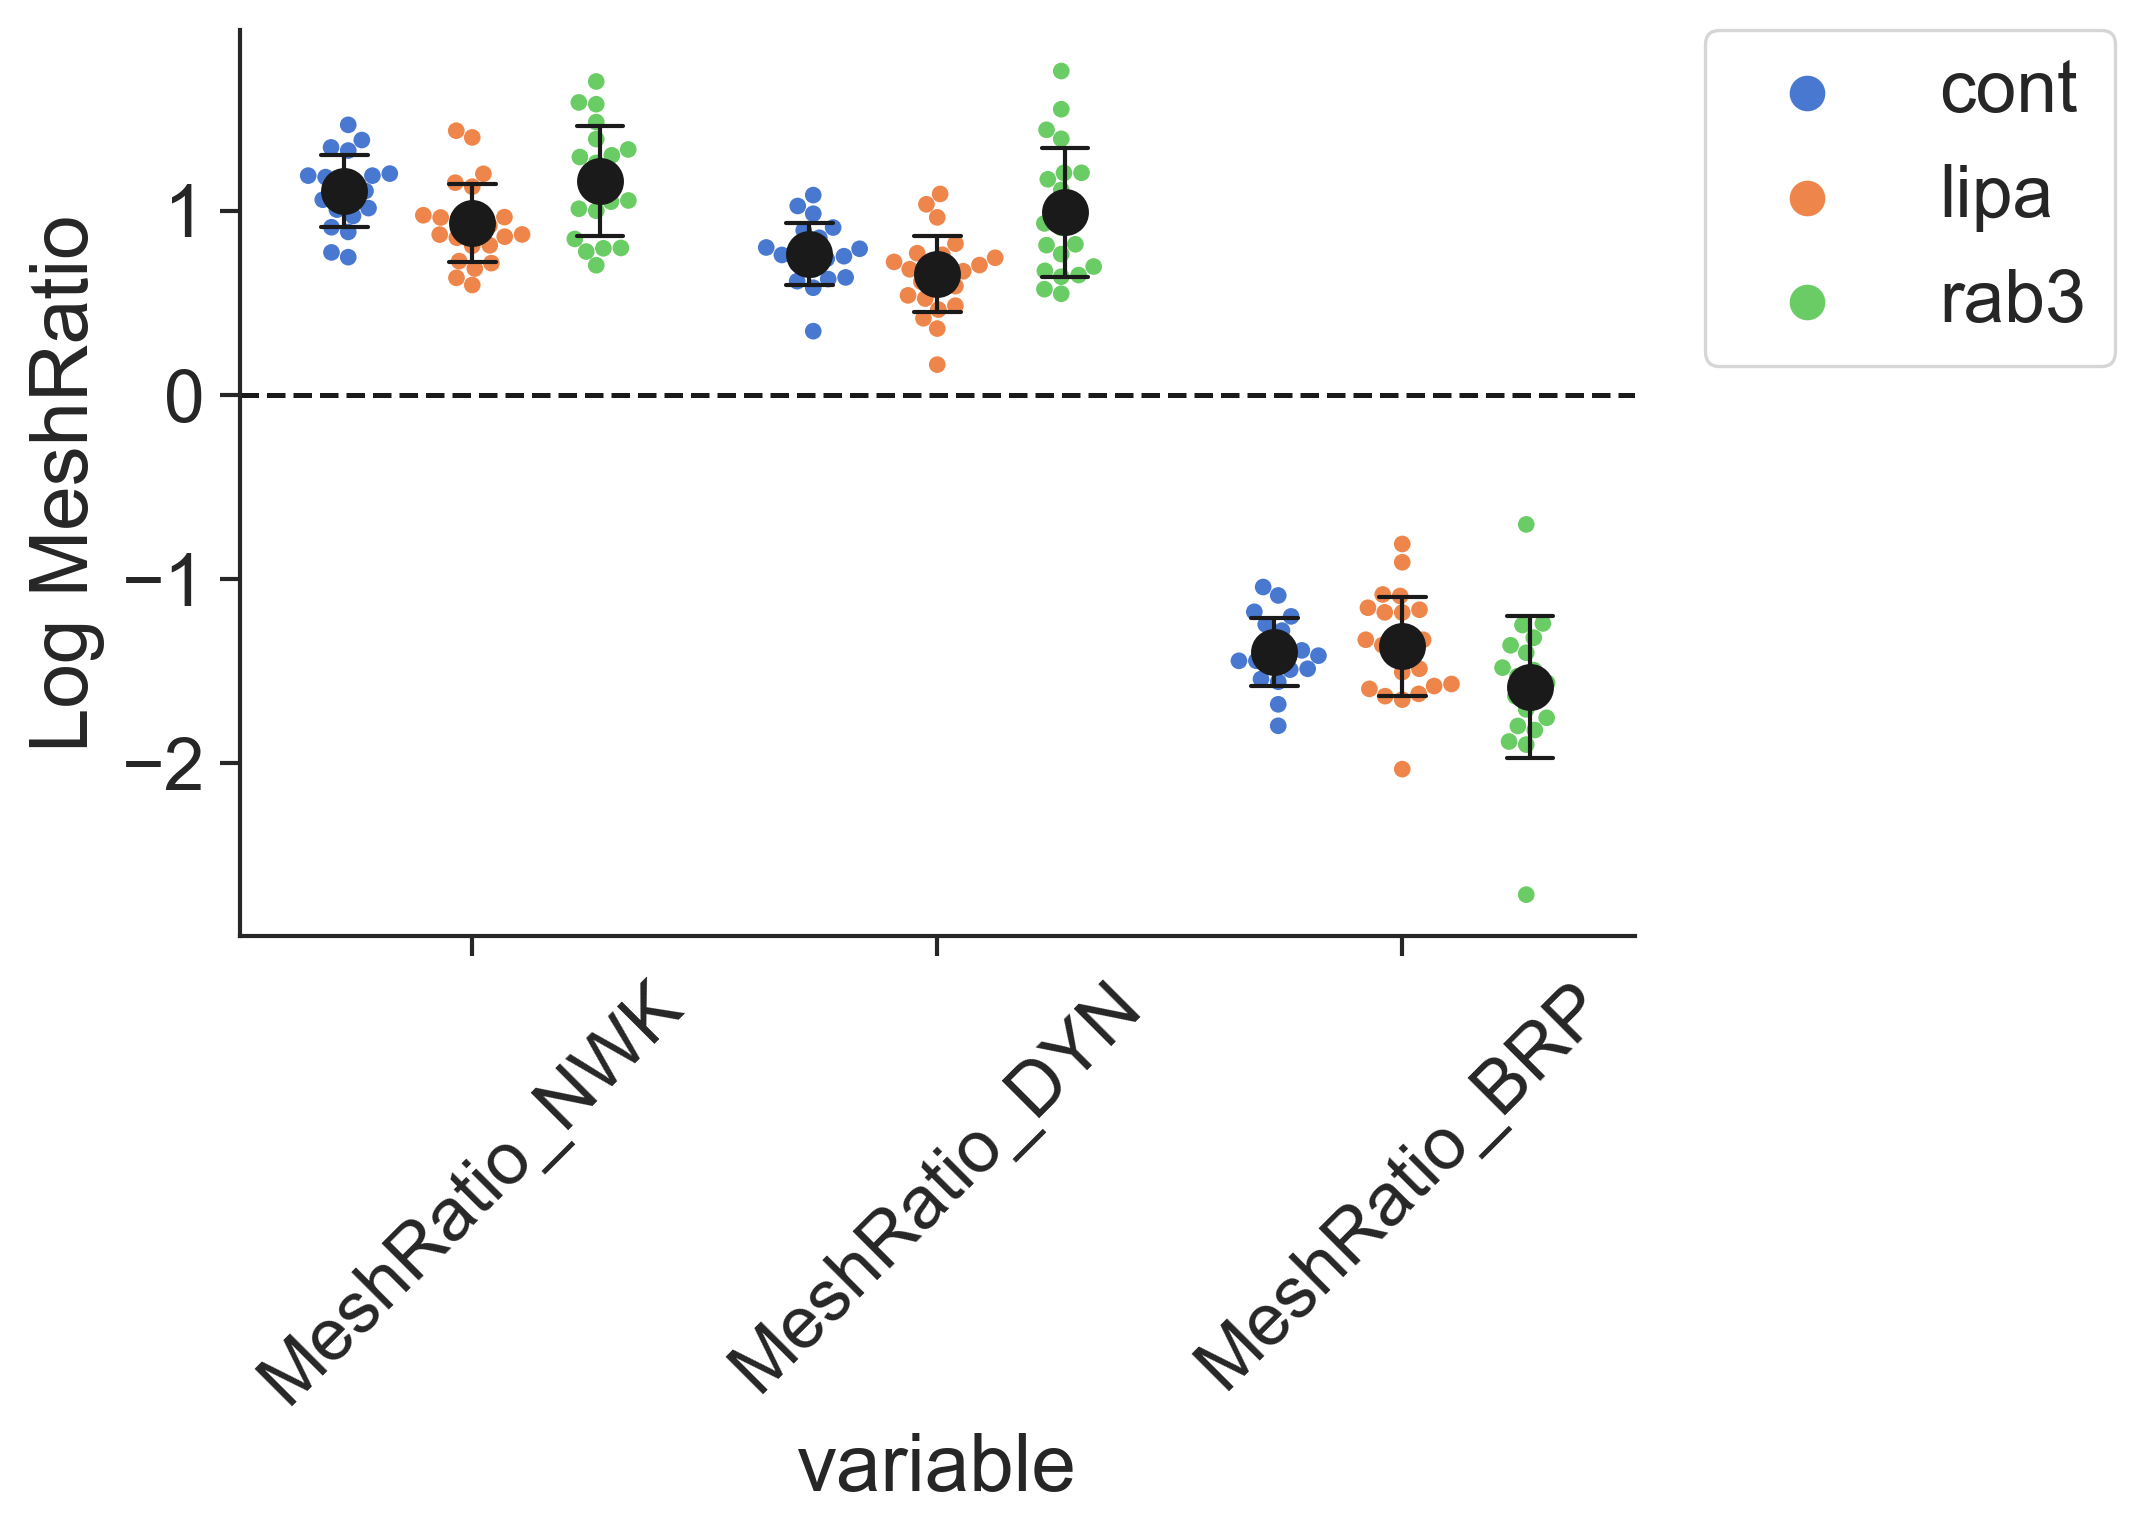

In [24]:
FIG = "SD622_MeshRatioSwarm"

# Calculate log2 of all ratios
compRatio['nmjid']= compRatio['Image'].str.split("Out-", expand=True)[0]
LogRatio = np.log2(compRatio.loc[:, ["Ratio" in x for x in compRatio.columns]])
LogRatio[["Experiment", "nmjid", "geno"]]=compRatio.loc[:, ["Experiment", "nmjid", "geno"]]

# Calculate nmjid and Experiment level means for superplot
ImgMean = LogRatio.groupby(["Experiment", "nmjid", "geno"]).mean().reset_index()
ExpMean = LogRatio.groupby(["Experiment"]).mean().reset_index()

# Melt for plotting
ImgMean=ImgMean.melt(id_vars=["Experiment", "nmjid", "geno"], value_name="Log MeshRatio")

# Make an ordering vector specific to the MeshRatio columns
ratio_order = ["MeshRatio_"+c for c in data_order] + ["MeshRatio_BRP"]

# Plot
sp = sns.swarmplot(data=ImgMean, x="variable", y="Log MeshRatio", hue="geno", size=4, dodge=True, order=ratio_order, zorder=0)
#sns.swarmplot(data=ExpMean, x="variable", y="Log MeshRatio", hue="Experiment", size=8, 
#              edgecolor="k", linewidth=1, order=ratio_order, zorder=0, ax=sp)

sns.pointplot(data=ImgMean, x="variable", y="Log MeshRatio",
              ci='sd', palette=['k'], scale=1.6,
              join=False, capsize=.1, errwidth=1, order=ratio_order, hue="geno", dodge=.55, ax=sp)

handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
#sp.set_ylim(.4, 1.6)

# Draw horizontal dashed line at 0
ax1 = sp.axes
ax1.axhline(0, ls='--', color='k')

plt.savefig(os.path.join(savepath, FIG + ".svg"))
None

## Fig 2E Spottiness

c:\Users\sdels\miniconda3\envs\defects\envs\segment_paz\envs\paz_analysis\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


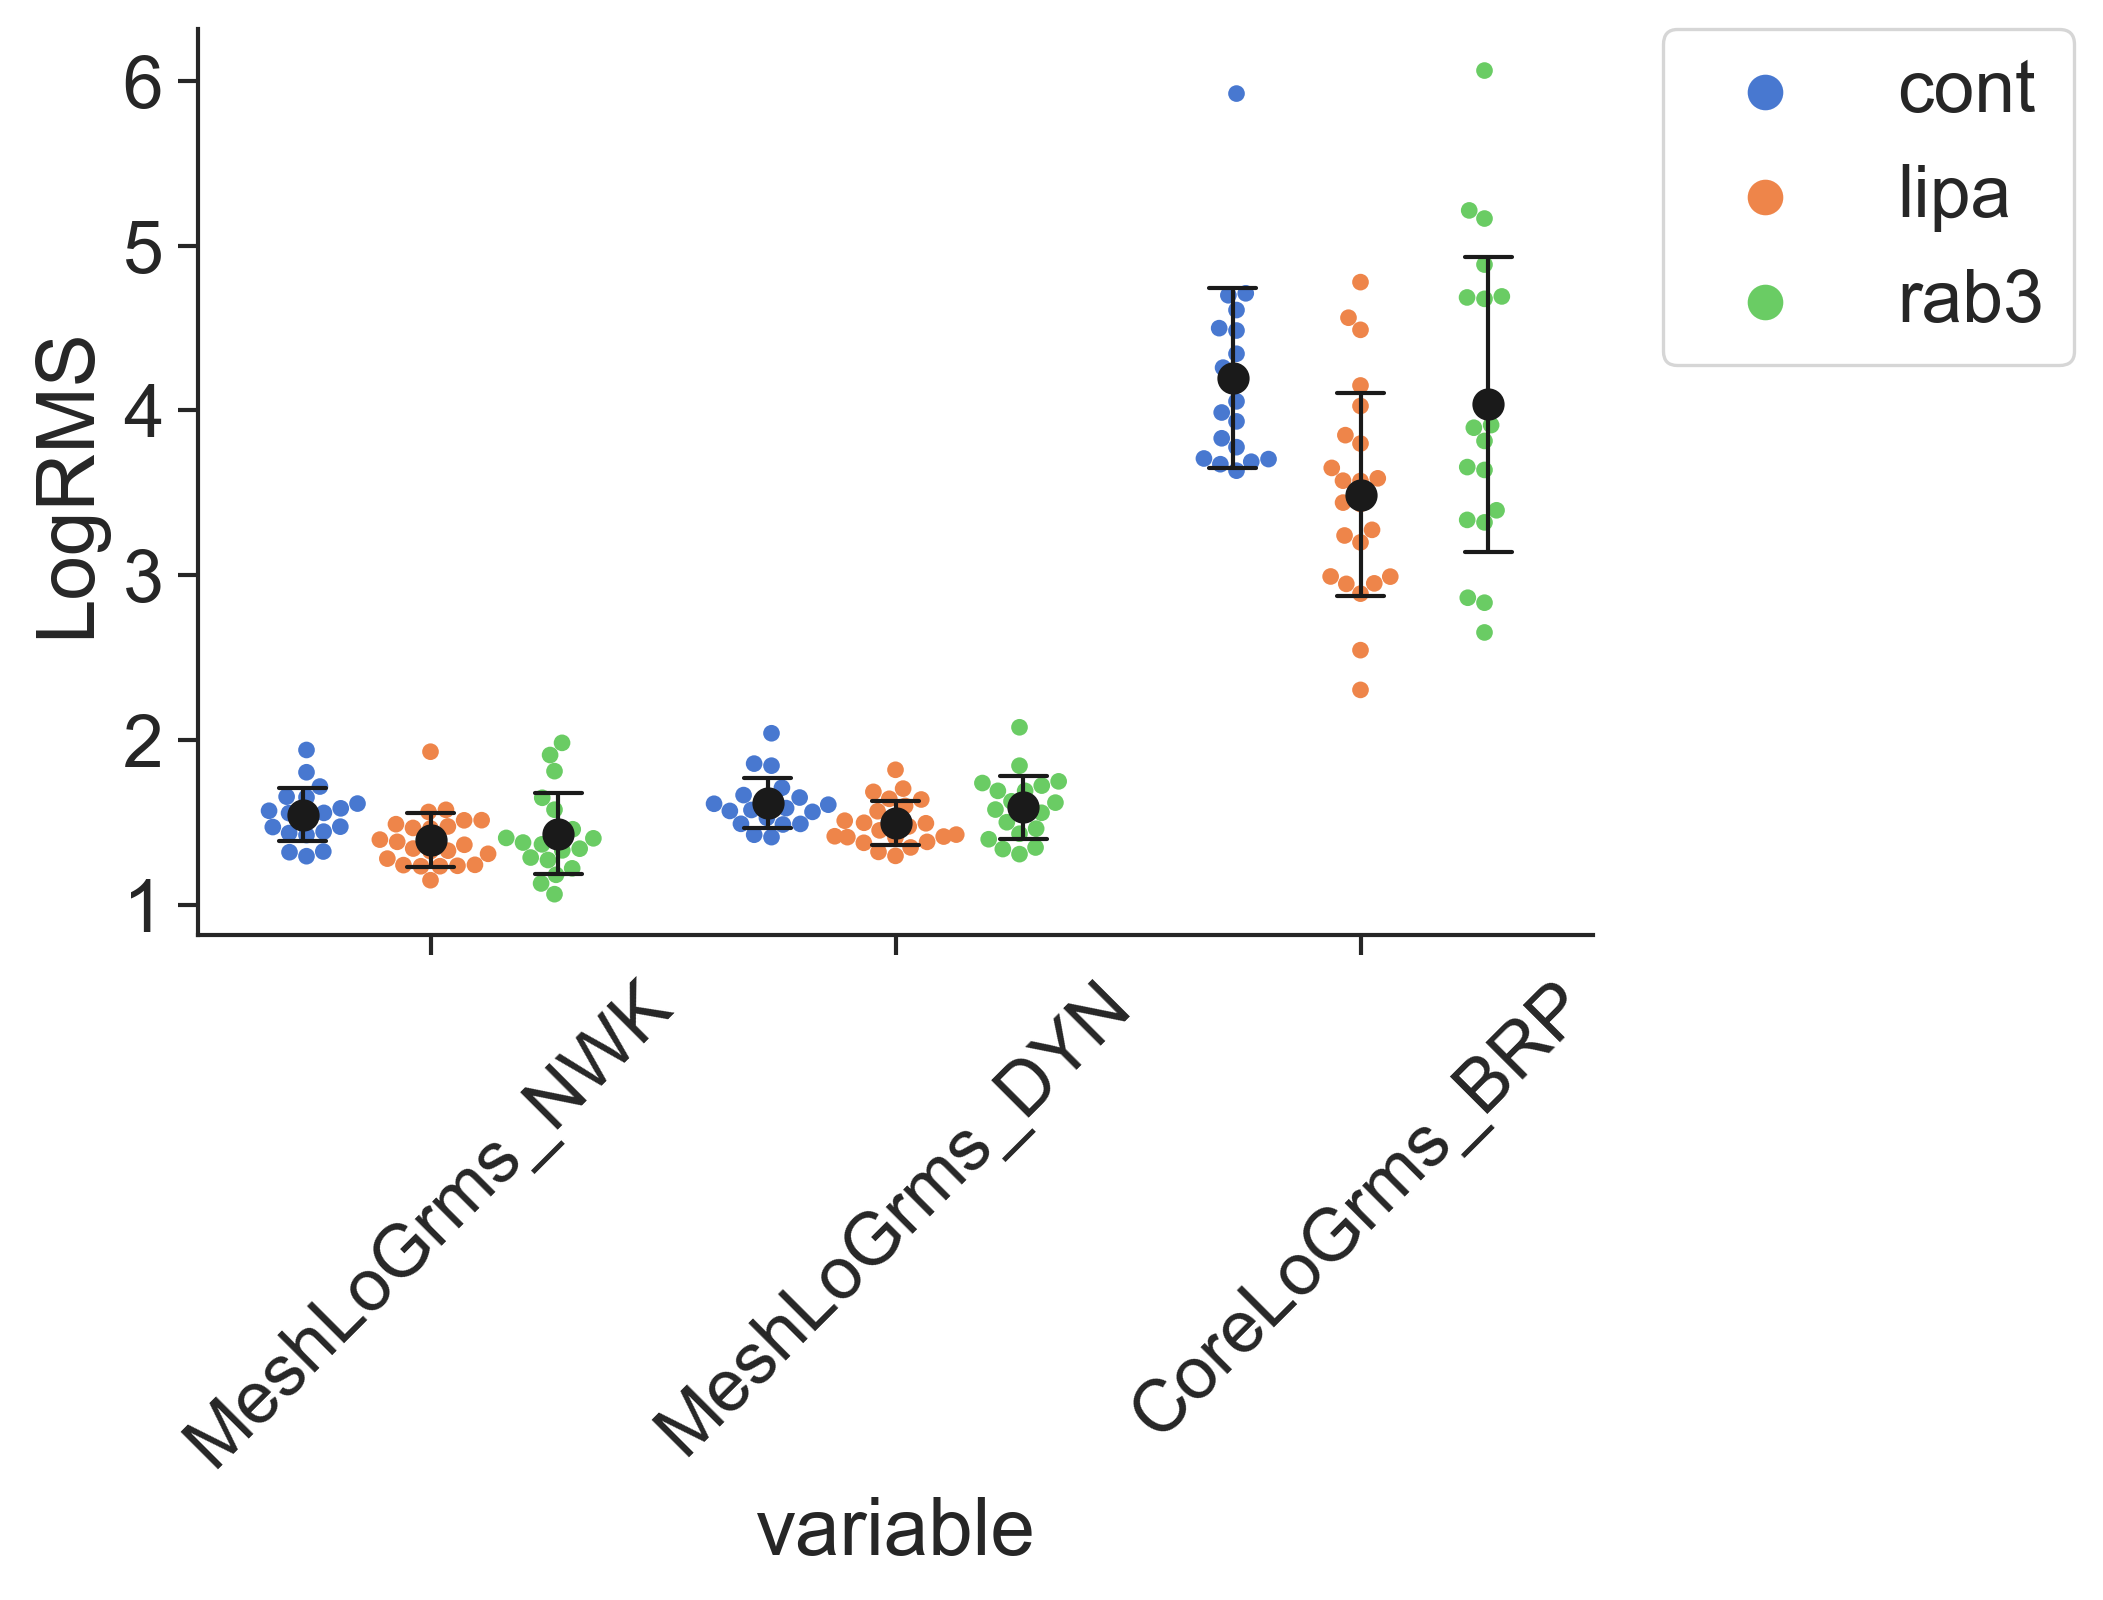

In [73]:
FIG = 'SD622_Spotty'
# Subset spottiness measurements:
spotty = agg.subset_data(CompMeshF_AZ, ["geno", "LoGrms"])
spotty['nmjid']= spotty['Image'].str.split("Out-", expand=True)[0]

# Make order vector for spottiness columns
spot_order = np.array([[f"CoreLoGrms_{chan}", f"MeshLoGrms_{chan}"] for chan in data_order]).flatten()

# Calculate nmjid and Experiment level means for superplot
ImgMean = spotty.groupby(["Experiment", "nmjid", "geno"]).mean().reset_index()

# Melt for plotting
ImgMean=ImgMean.melt(id_vars=["Experiment", "nmjid", "geno"], value_name="LogRMS")

# Make an ordering vector specific to the MeshRatio columns
spot_order = [f"MeshLoGrms_{c}" for c in data_order] + ["CoreLoGrms_BRP"]

# Plot
sp = sns.swarmplot(data=ImgMean, x="variable", y="LogRMS", hue="geno", dodge=True, size=4, order=spot_order, zorder=0)
#sns.swarmplot(data=ExpMean, x="variable", y="LogRMS", hue="Experiment", size=8, 
#              edgecolor="k", linewidth=1, order=spot_order, zorder=0, ax=sp)

sns.pointplot(data=ImgMean, x="variable", y="LogRMS",
              ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, order=spot_order, hue="geno", dodge=0.55, ax=sp)

handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.savefig(os.path.join(savepath, FIG + ".svg"))
None

In [27]:
ImgMean = spotty.groupby(["Experiment", "nmjid"]).mean().reset_index().drop(["Experiment", "nmjid"], axis=1)
totest = ImgMean.loc[:, [f"MeshLoGrms_{c}" for c in data_order]]
analysis = agg.compareGroups(totest)
analysis['posthoc'].to_csv(os.path.join(statspath, FIG+"_Posthoc.csv"))

ValueError: Need at least two groups in stats.kruskal()

## Mesh Area and AZ area

In [88]:
sums=CompMesh.groupby(["Image", "geno"]).sum()
azdensity = pd.DataFrame({"density":sums.AZcount/sums.Area}).reset_index()
azdensity

,Image,geno,density
0,SD622_cont_L01_m4__2022_06_10__17_03_07-Airysc...,cont,4.245087
1,SD622_cont_L01_m4__2022_06_10__17_06_59-Airysc...,cont,4.575185
2,SD622_cont_L01_m4__2022_06_10__17_11_12-Airysc...,cont,3.612098
3,SD622_cont_L02_m4__2022_06_10__17_21_21-Airysc...,cont,3.889464
4,SD622_cont_L02_m4__2022_06_10__17_26_56-Airysc...,cont,2.878182
...,...,...,...
56,SD622_rab3_L04_m4_a3_2022_06_11__13_20_17-Airy...,rab3,1.221605
57,SD622_rab3_L04_m4_a4_2022_06_11__13_26_38-Airy...,rab3,1.498571
58,SD622_rab3_L05_m4_a3_2022_06_11__13_31_41-Airy...,rab3,2.254046
59,SD622_rab3_L05_m4_a3_2022_06_11__13_41_52-Airy...,rab3,2.006586


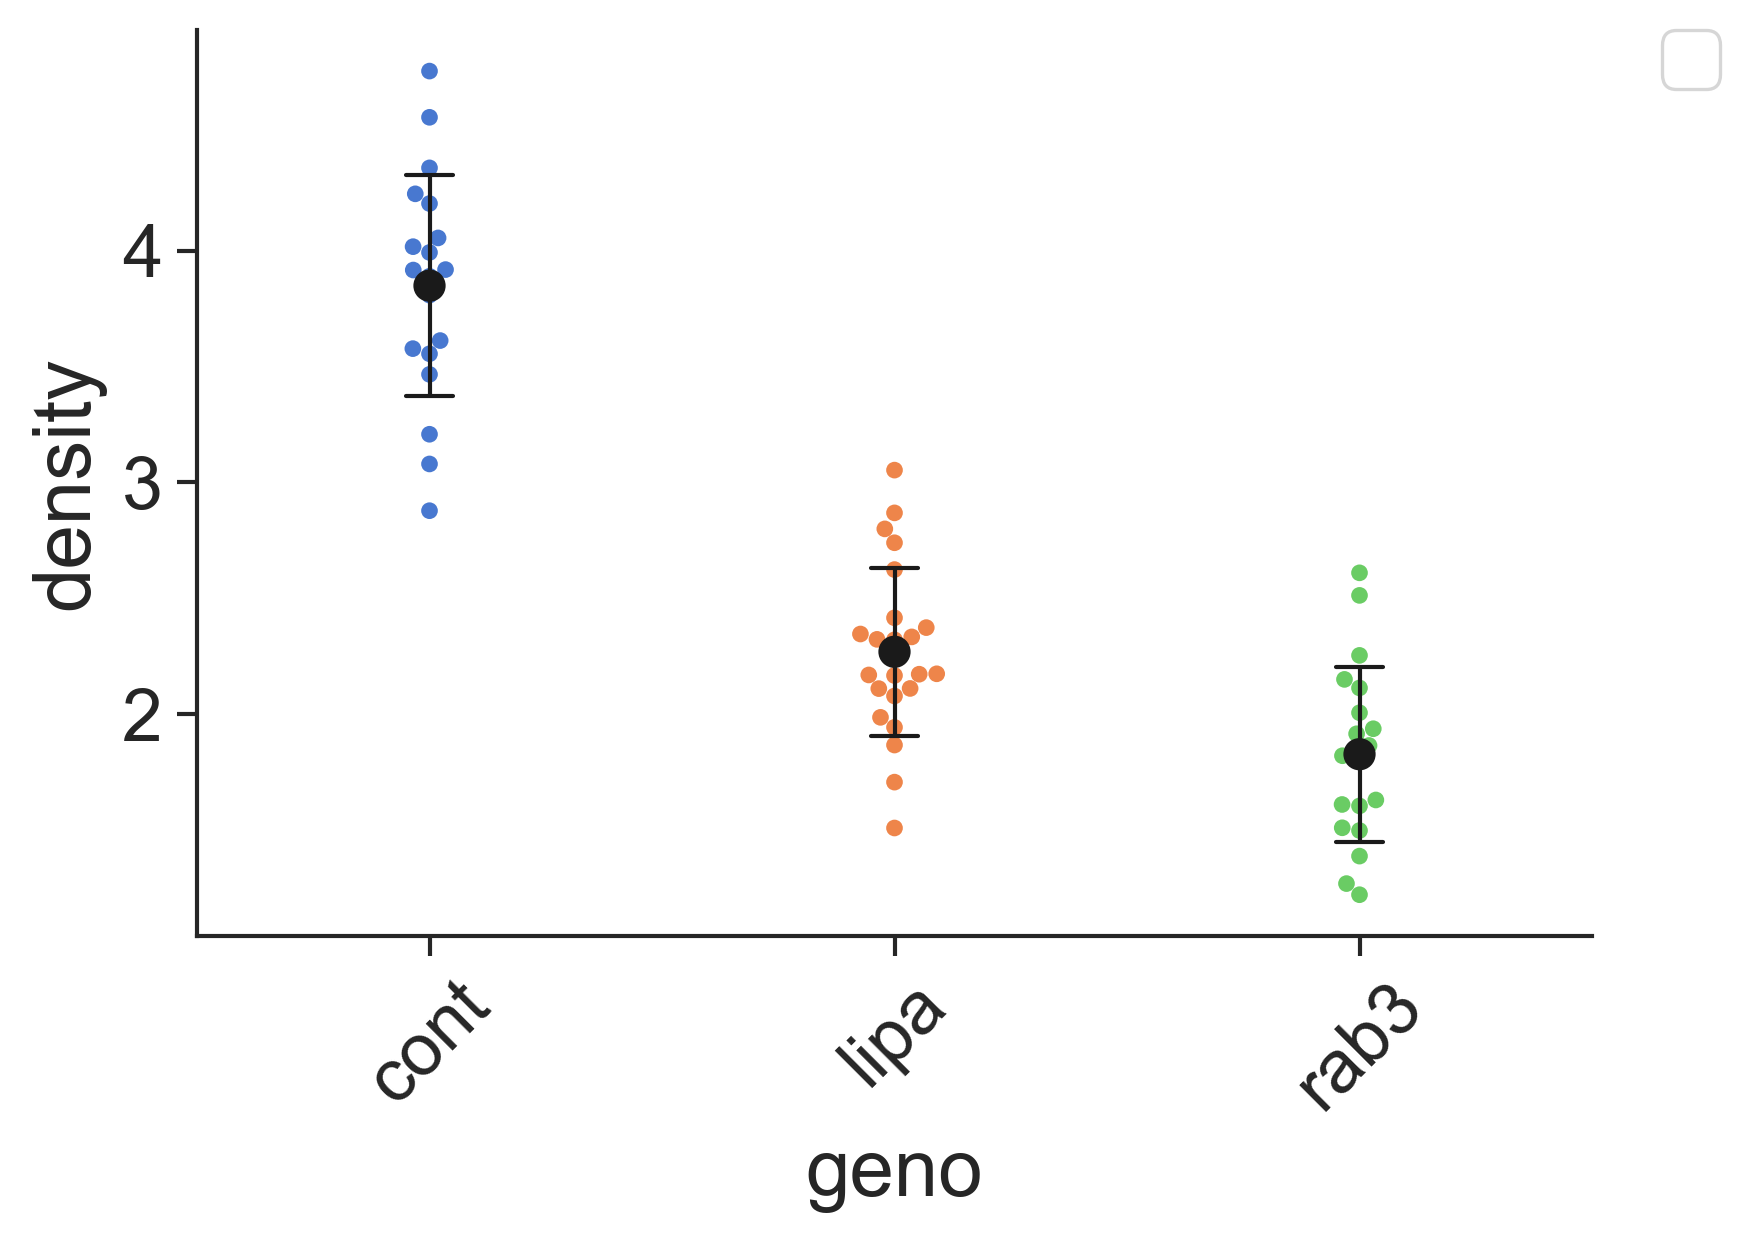

In [93]:
# Plot
sp = sns.swarmplot(data=azdensity, x="geno", y="density", size=4, zorder=0)
#sns.swarmplot(data=ExpMean, x="variable", y="LogRMS", hue="Experiment", size=8, 
#              edgecolor="k", linewidth=1, order=spot_order, zorder=0, ax=sp)

sns.pointplot(data=azdensity, x="geno", y="density",
              ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, ax=sp)

handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
None
plt.savefig(os.path.join(savepath, "SD622_AZdensity.svg"))

In [98]:
ImgMean=CompMesh.groupby(["Image", "geno"]).mean().reset_index()
ImgMean.melt(id_vars=["Image", "geno"])

,Image,geno,variable,value
0,SD622_cont_L01_m4__2022_06_10__17_03_07-Airysc...,cont,AZcount,0.979592
1,SD622_cont_L01_m4__2022_06_10__17_06_59-Airysc...,cont,AZcount,1.187500
2,SD622_cont_L01_m4__2022_06_10__17_11_12-Airysc...,cont,AZcount,0.992647
3,SD622_cont_L02_m4__2022_06_10__17_21_21-Airysc...,cont,AZcount,0.931034
4,SD622_cont_L02_m4__2022_06_10__17_26_56-Airysc...,cont,AZcount,0.754098
...,...,...,...,...
2923,SD622_rab3_L04_m4_a3_2022_06_11__13_20_17-Airy...,rab3,EntrD8_BRP,4.866067
2924,SD622_rab3_L04_m4_a4_2022_06_11__13_26_38-Airy...,rab3,EntrD8_BRP,5.203390
2925,SD622_rab3_L05_m4_a3_2022_06_11__13_31_41-Airy...,rab3,EntrD8_BRP,5.291788
2926,SD622_rab3_L05_m4_a3_2022_06_11__13_41_52-Airy...,rab3,EntrD8_BRP,5.110708


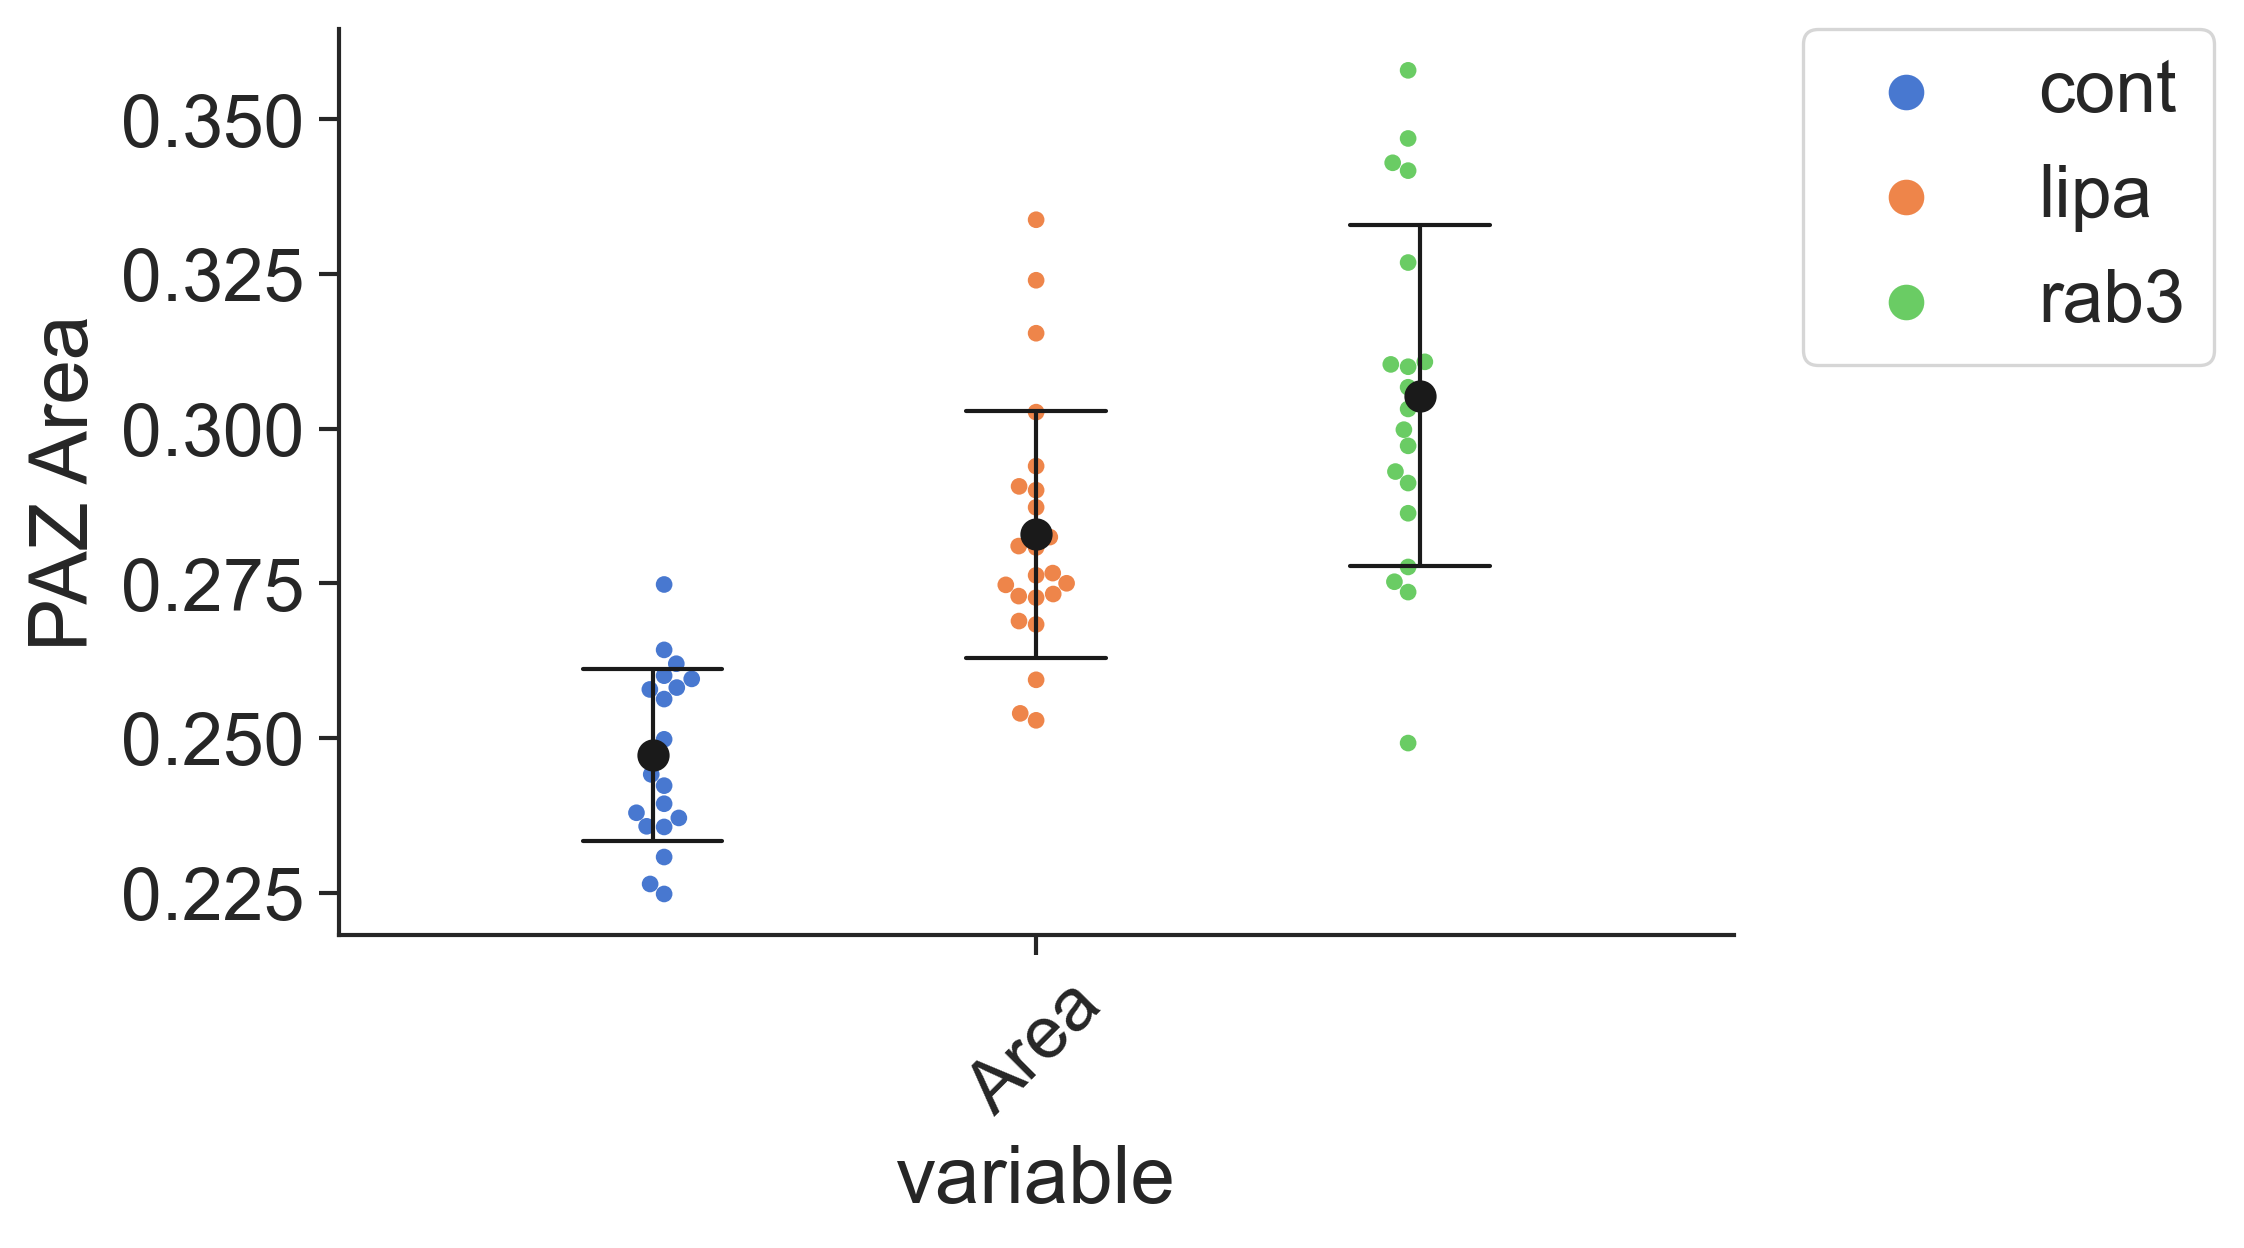

In [105]:
ImgMean=CompMesh.groupby(["Image", "geno"]).mean().reset_index().melt(id_vars=["geno", "Image"])
sp = sns.swarmplot(data=ImgMean, x="variable", y="value", hue="geno", dodge=True, size=4, order=["Area"], zorder=0)
#sns.swarmplot(data=ExpMean, x="variable", y="LogRMS", hue="Experiment", size=8, 
#              edgecolor="k", linewidth=1, order=spot_order, zorder=0, ax=sp)

sns.pointplot(data=ImgMean, x="variable", y="value", hue="geno", dodge=0.55, 
              order=["Area"], ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, ax=sp)

handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
sp.set_ylabel("PAZ Area")
None
plt.savefig(os.path.join(savepath, "SD622_CompArea.svg"))

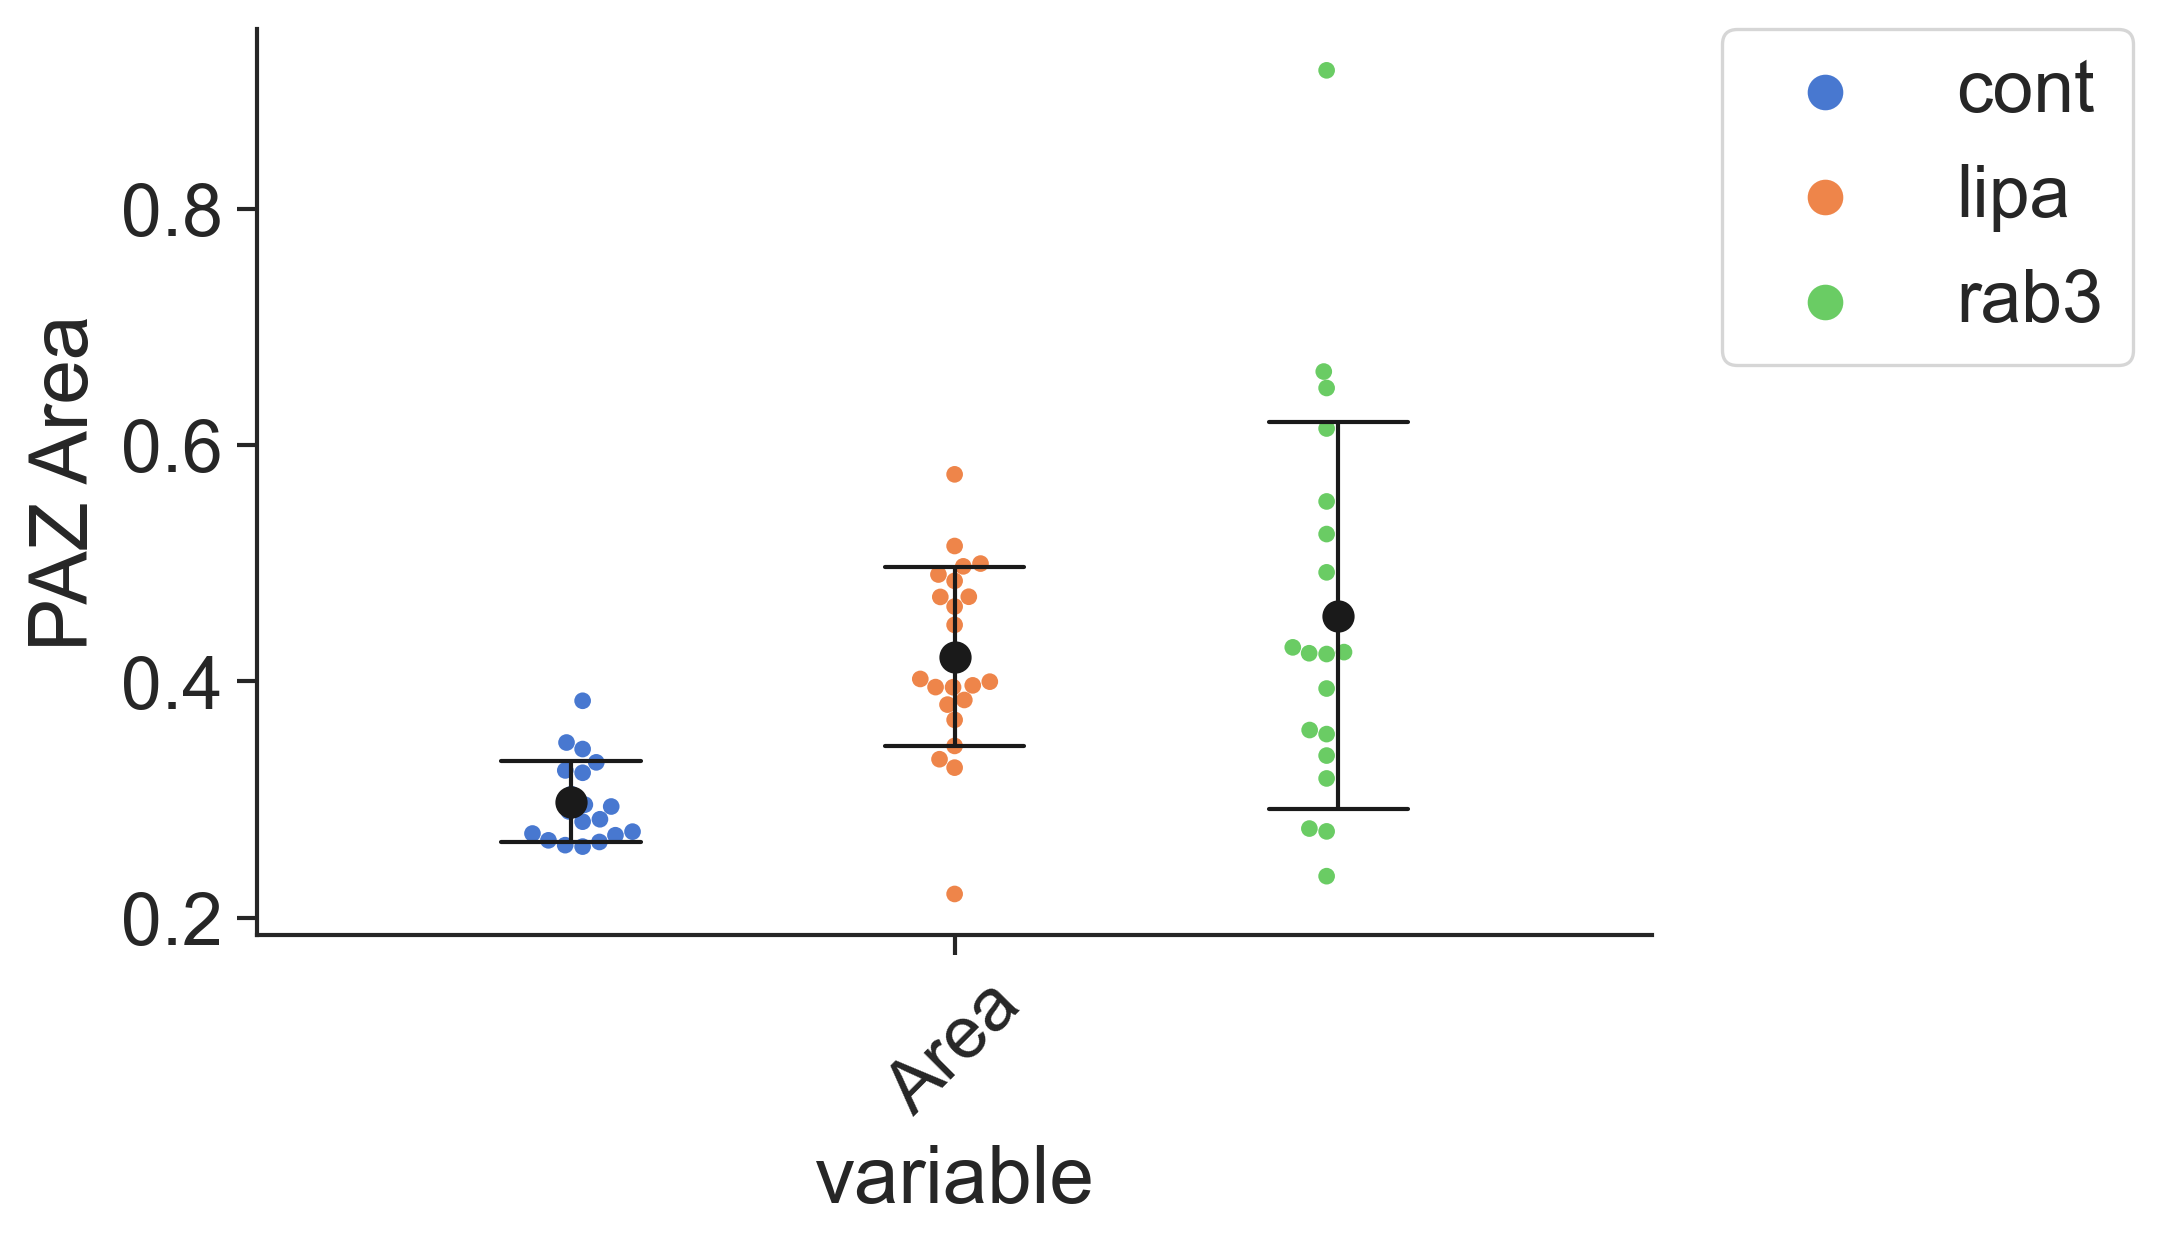

In [104]:
ImgMean=CompMeshF_AZ.groupby(["Image", "geno"]).mean().reset_index().melt(id_vars=["geno", "Image"])
sp = sns.swarmplot(data=ImgMean, x="variable", y="value", hue="geno", dodge=True, size=4, order=["Area"], zorder=0)
#sns.swarmplot(data=ExpMean, x="variable", y="LogRMS", hue="Experiment", size=8, 
#              edgecolor="k", linewidth=1, order=spot_order, zorder=0, ax=sp)

sns.pointplot(data=ImgMean, x="variable", y="value", hue="geno", dodge=0.55, 
              order=["Area"], ci='sd', palette=['k'], scale=1.1,
              join=False, capsize=.1, errwidth=1, ax=sp)

handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2

l = plt.legend(handles[0:n], labels[0:n], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
sp.set_ylabel("PAZ Area")
None
plt.savefig(os.path.join(savepath, "SD622_CompF-AZ_Area.svg"))

## Fig 4B Intensity correlations/heatmap to AZ integrated density

**For additional code and analysis, see SD601h**

In [162]:
PCC_matrix = Composite_1AZ.groupby("geno").corr()
# Pivot to a nice table
PCCazid = PCC_matrix.AZidtotal #.reset_index(level=0)

PCCazid=PCCazid.unstack("geno")
PCCazid.index=PCCazid.index.str.split("_", expand=True)

table=PCCazid.unstack().loc[Intensity_cols].drop(np.nan, axis=1, level=1)

table

geno            cont                          lipa                      \
                 BRP       DYN       NWK       BRP       DYN       NWK   
CoreMean    0.651253  0.181521  0.075596  0.660848  0.193245  0.120753   
CoreCoV    -0.105987  0.027434  0.021797 -0.045977  0.054221  0.077980   
CoreLoGrms  0.300512  0.204211  0.094211  0.391332  0.197988  0.126025   
MeshMean    0.283132  0.316404  0.264166  0.315661  0.213553  0.250031   
MeshCoV     0.136807  0.085231  0.061399  0.269607  0.095431  0.020833   
MeshLoGrms  0.182651  0.280525  0.208658  0.283153  0.157127  0.125822   
MeshRatio  -0.236311 -0.032641  0.056955 -0.330365 -0.052889 -0.008432   

geno            rab3                      
                 BRP       DYN       NWK  
CoreMean    0.634583  0.244395  0.163565  
CoreCoV    -0.002735  0.043094  0.092665  
CoreLoGrms  0.402531  0.269558  0.162074  
MeshMean    0.343939  0.187239  0.198423  
MeshCoV     0.418145  0.222257  0.177853  
MeshLoGrms  0.309068  0.178451  0.178523  
MeshRatio  -0.215825 -0.144953 -0.100462

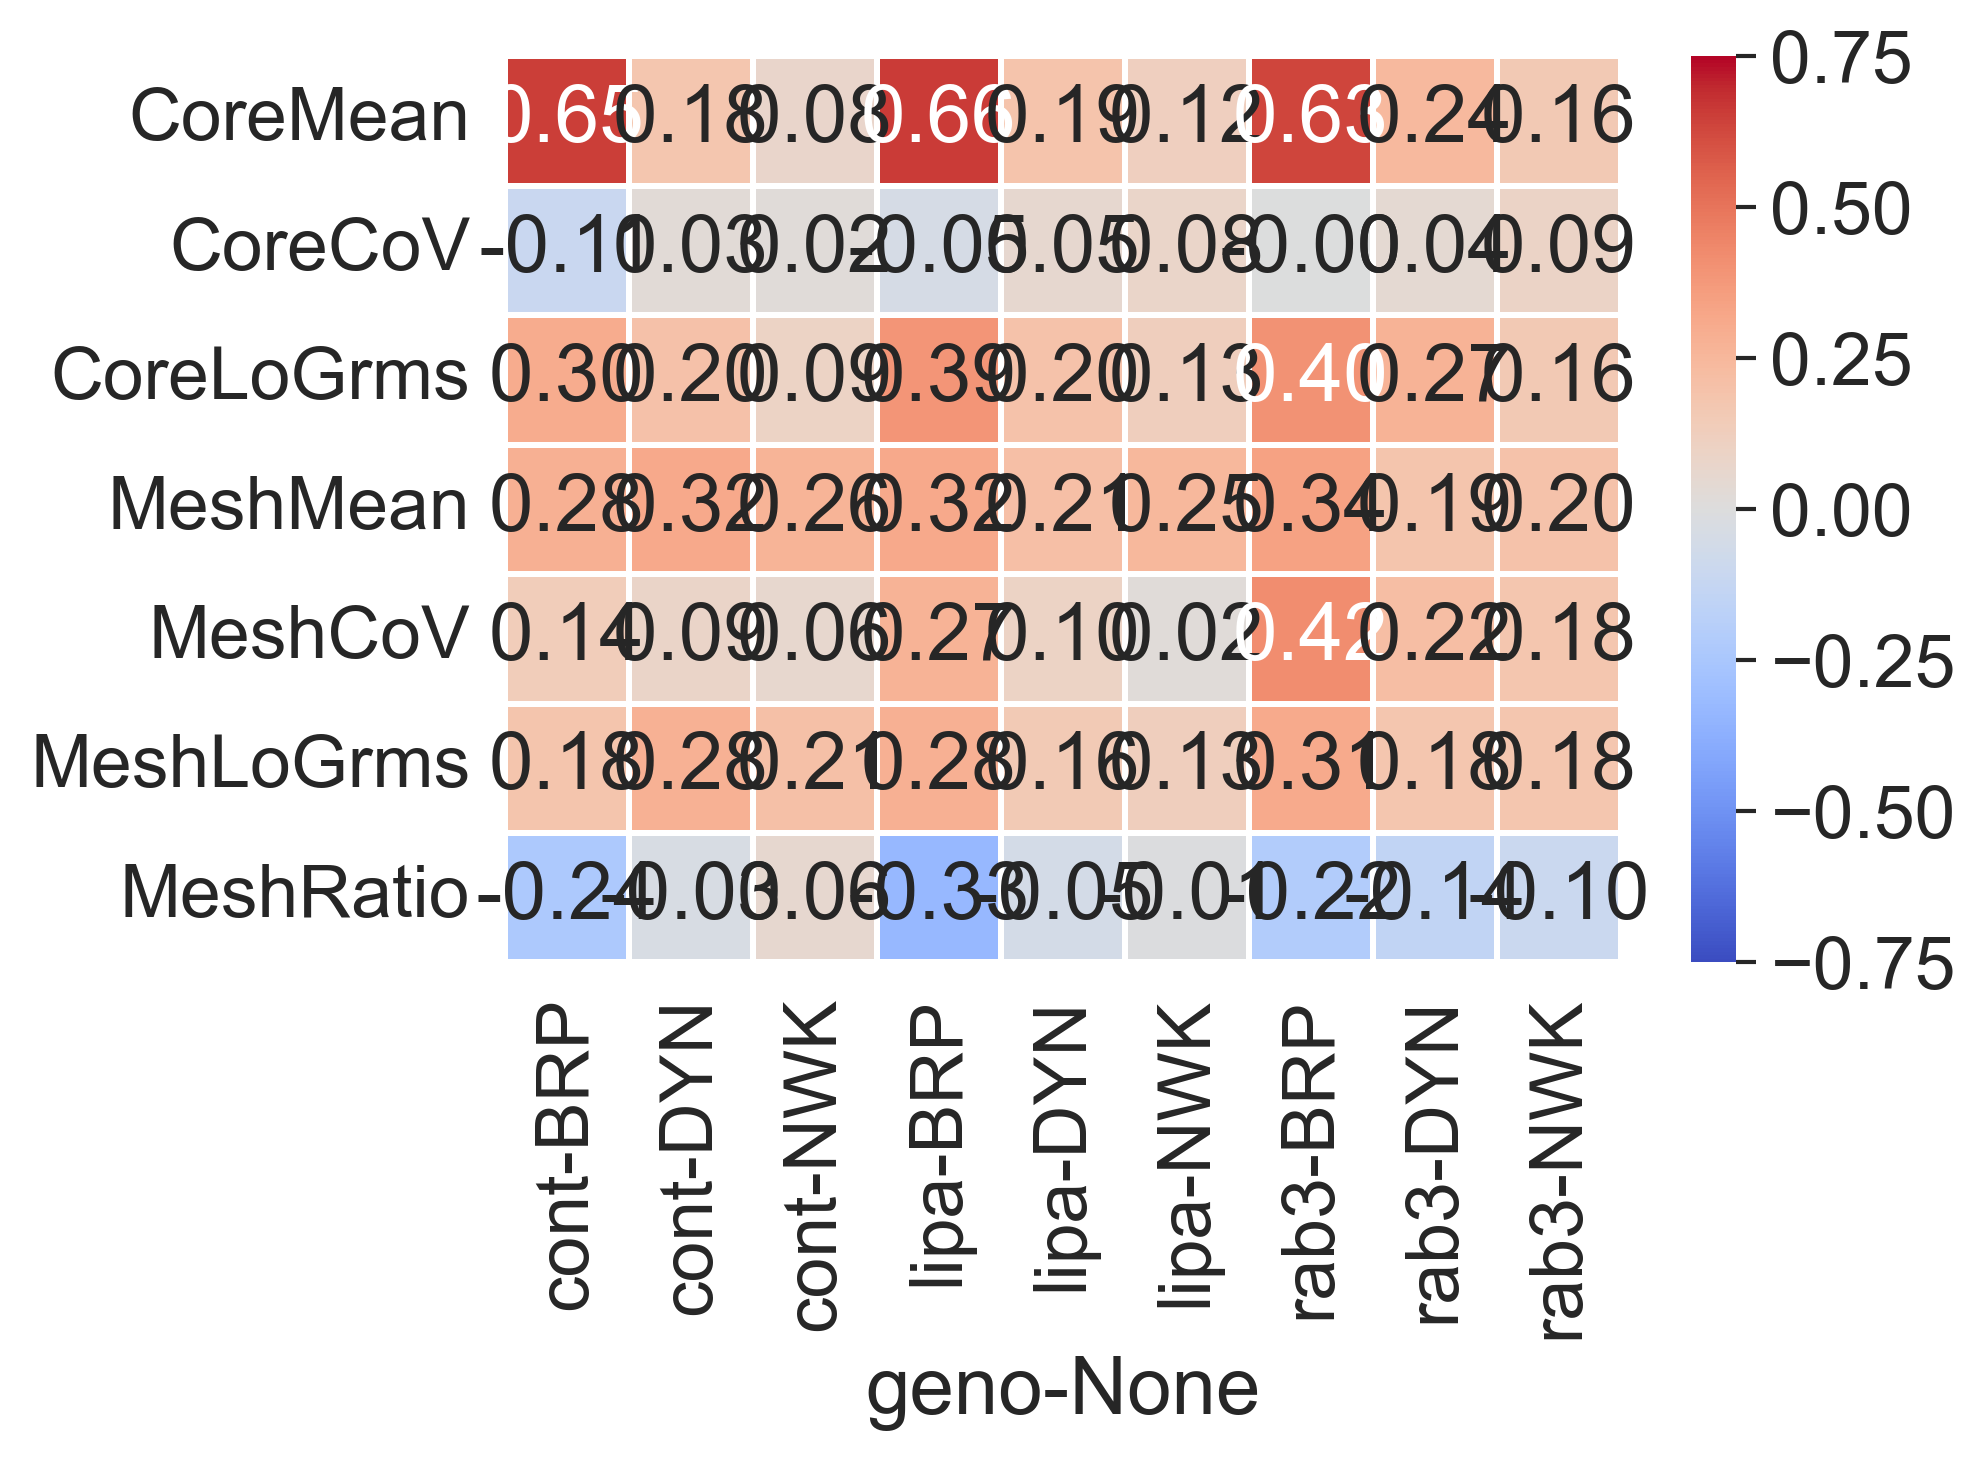

In [167]:
FIG = "SD622_AZ-PAZmatrix"
# Define columns to analyze for this panel:
Intensity_cols = ["CoreMean", "CoreCoV", "CoreLoGrms", "MeshMean", "MeshCoV", "MeshLoGrms", "MeshRatio"]

# Calculate Correlation matrix for single AZ containing meshes
PCC_matrix = Composite_1AZ.groupby("geno").corr()
# Pivot to a nice table
PCCazid = PCC_matrix.AZidtotal #.reset_index(level=0)

PCCazid=PCCazid.unstack("geno")
PCCazid.index=PCCazid.index.str.split("_", expand=True)

table=PCCazid.unstack().loc[Intensity_cols].drop(np.nan, axis=1, level=1)
table2=table
# Reorder columns to match other graphs
#table2 = table.reindex(["NWK", "DYN", "BRP"], level=1)

# Make heatmap
hm = sns.heatmap(data=table2, cmap='coolwarm', vmin=-.75, vmax=.75,
                 linewidth=1, center=0, annot=True, fmt='1.2f')
hm.tick_params(bottom=False, left=False)
plt.savefig(os.path.join(savepath, FIG + ".svg"))

In [37]:
PCCazid.to_csv(os.path.join(savepath, "TableS1.csv"))

## Fig 4C-D high vs low AZid meshes

## Fig 4D mean mesh in high-lo

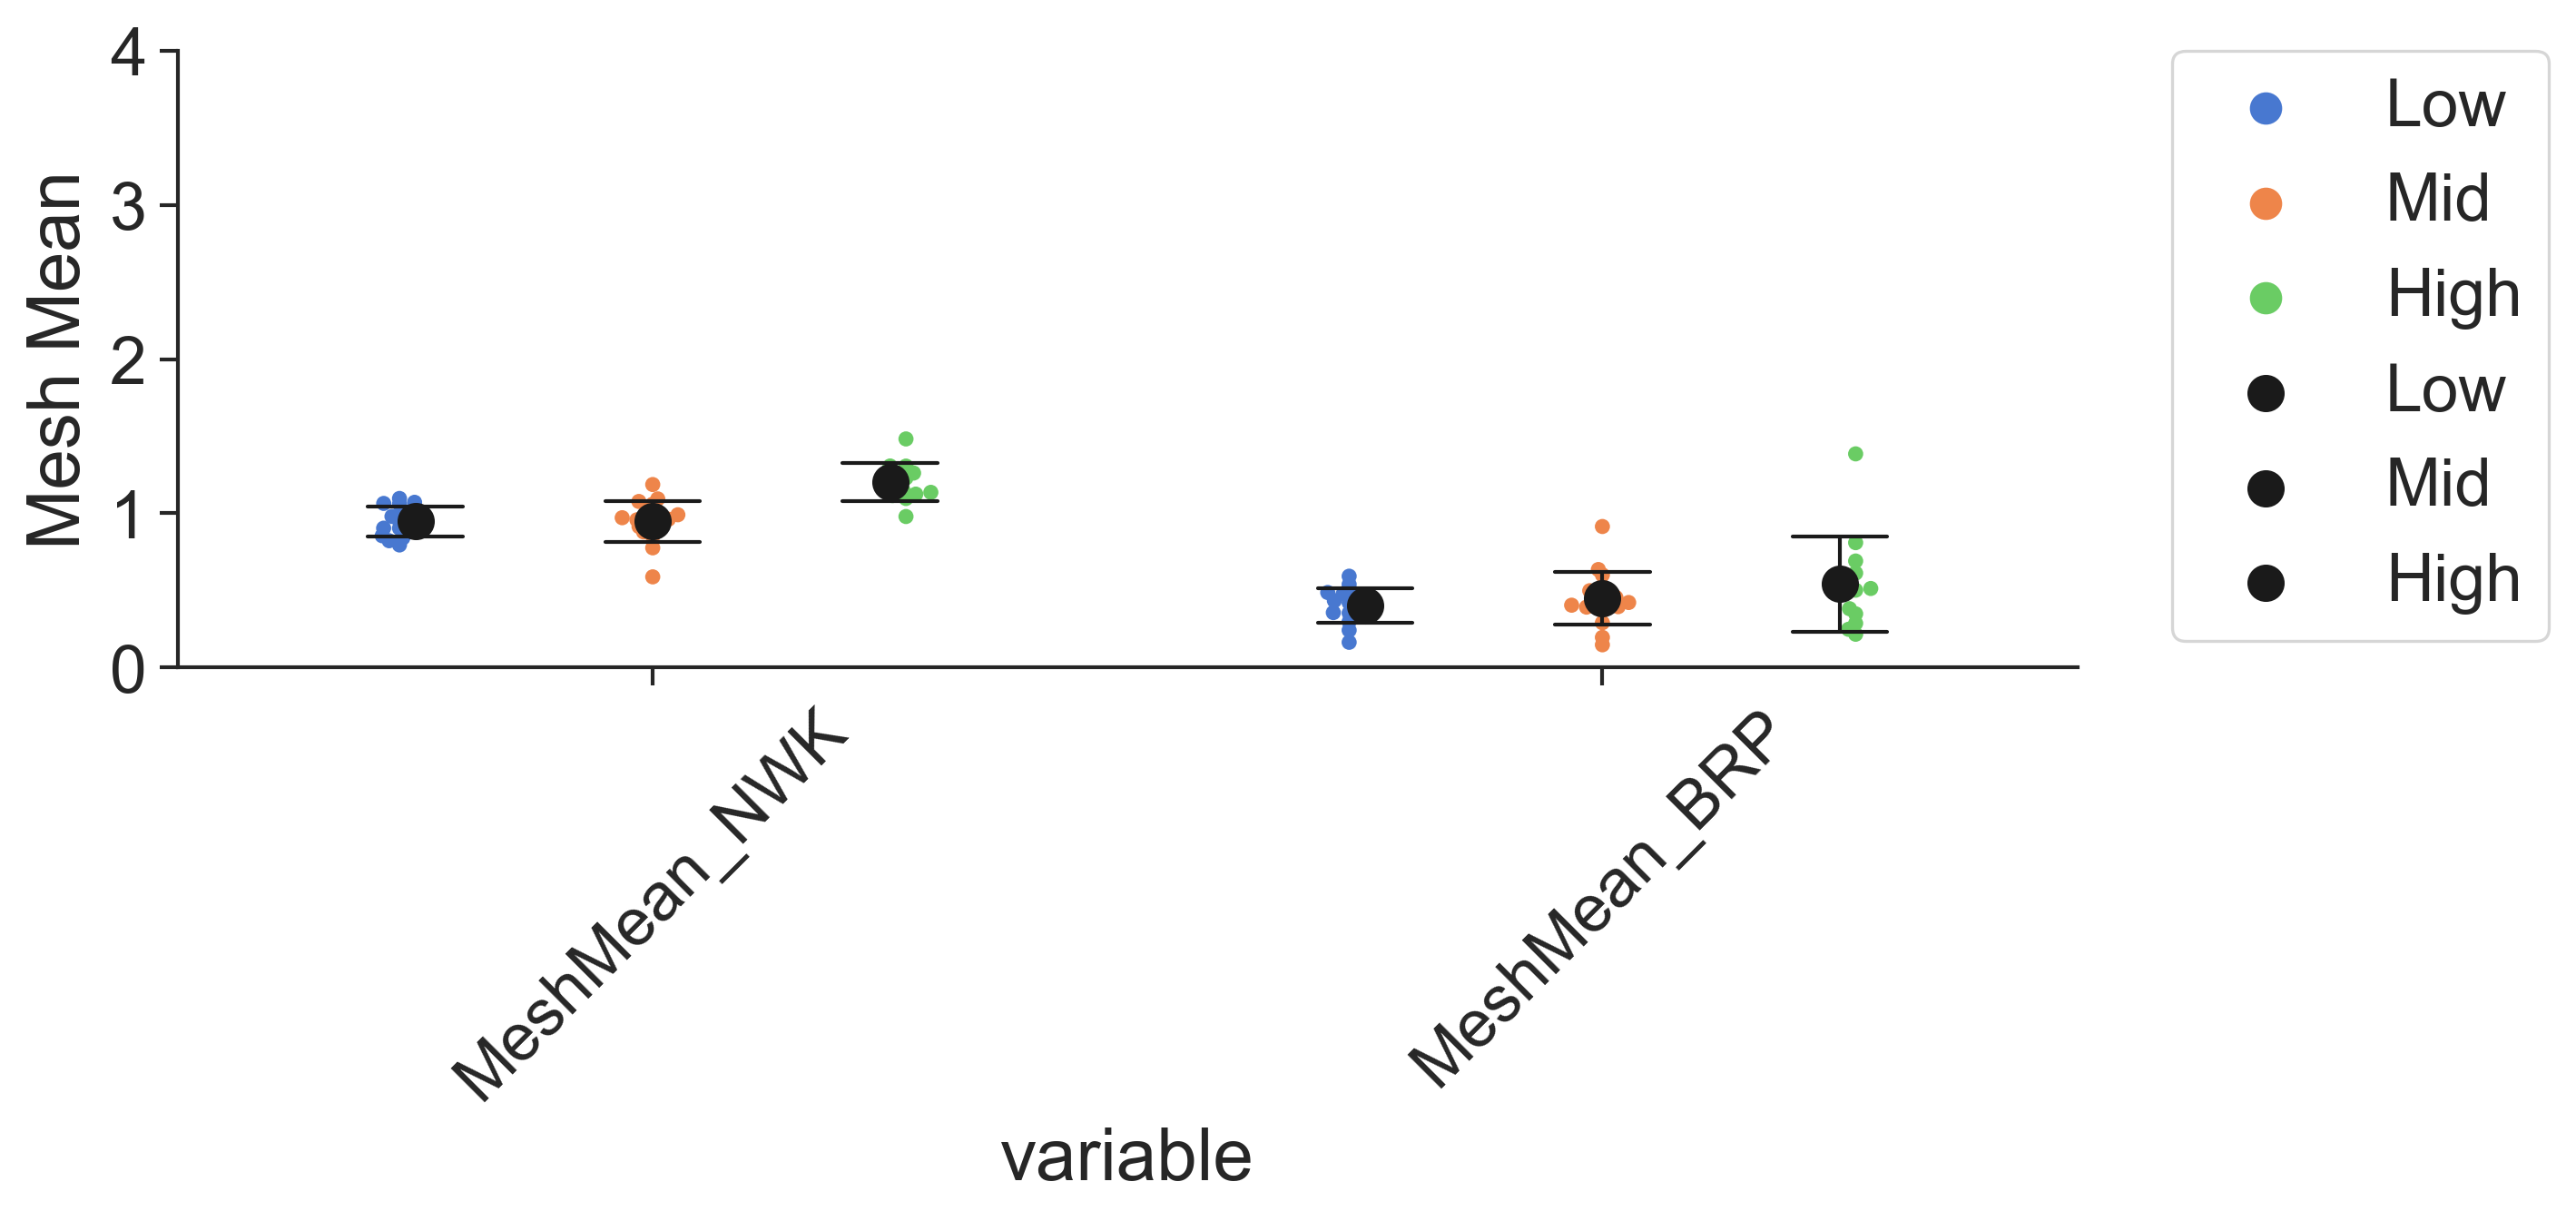

In [39]:
FIG = "Fig 4D_MeshMeanBinned"
# Make figure with binned AZid meshes
plt.figure(figsize=(9,3))
# Create a copy of the 1AZ filtered dataset and bin by AZ-id quantile
az1copy = Composite_1AZ.copy()
azid = az1copy.AZidtotal
az1copy["bins"]="Mid"
az1copy.bins.where(azid>azid.quantile(.25), "Low", inplace=True)
az1copy.bins.where(azid<azid.quantile(.75), "High", inplace=True)

# Subset Mesh Mean data
cols = ["Experiment", "nmjid", "bins"] + [f"MeshMean_{chan}" for chan in data_order] + ["MeshMean_BRP"]
data = az1copy.loc[:, cols]

# Prep data for graphing
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index()
ExpMean = data.groupby(["Experiment", "bins"]).mean().reset_index()

ImgMean = ImgMean.melt(id_vars = ["Experiment", "nmjid", "bins"], value_name="Mesh Mean")
ExpMean = ExpMean.melt(id_vars = ["Experiment", "bins"], value_name="Mesh Mean")

# Plot data
sp = sns.swarmplot(data=ImgMean, x="variable", y="Mesh Mean", hue="bins", 
                   hue_order=["Low", "Mid", "High"], size=4, dodge=True, zorder=0)
sns.pointplot(data=ImgMean, x="variable", y="Mesh Mean",
              ci='sd', palette=['k'], scale=1.4,
              join=False, capsize=.1, errwidth=1, dodge=.5,
              hue="bins", hue_order=["Low", "Mid", "High"])
handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2
l = plt.legend(handles[0:], labels[0:], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.ylim((0,4))
plt.savefig(os.path.join(savepath, FIG + ".svg"))
None

In [40]:
# Stats for mesh mean
# Do a single anova or kw test for each channel
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index().drop(["Experiment", "nmjid"], axis=1)
ImgMean = ImgMean.pivot(columns = 'bins', values=ImgMean.columns.drop('bins'))
ImgMean.columns.names=[None, None]
#ImgMean = ImgMean.reset_index(drop=True)
chans=list(set([col[0] for col in ImgMean]))
analyses = {chan:agg.compareGroups(ImgMean[chan]) for chan in chans}

all_posthocs = pd.concat({key:chan['posthoc'] for key,chan in analyses.items()})
all_posthocs.to_csv(os.path.join(statspath, f"{FIG}-Posthoc_ByChannel.csv"))

Performed Kruskal-Wallis: test statistic = 1.2568422717924363 p-value:0.5334333552585555
Performed Kruskal-Wallis: test statistic = 20.38063597532036 p-value:3.753195000276628e-05


## Fig 4C Core Mean binned

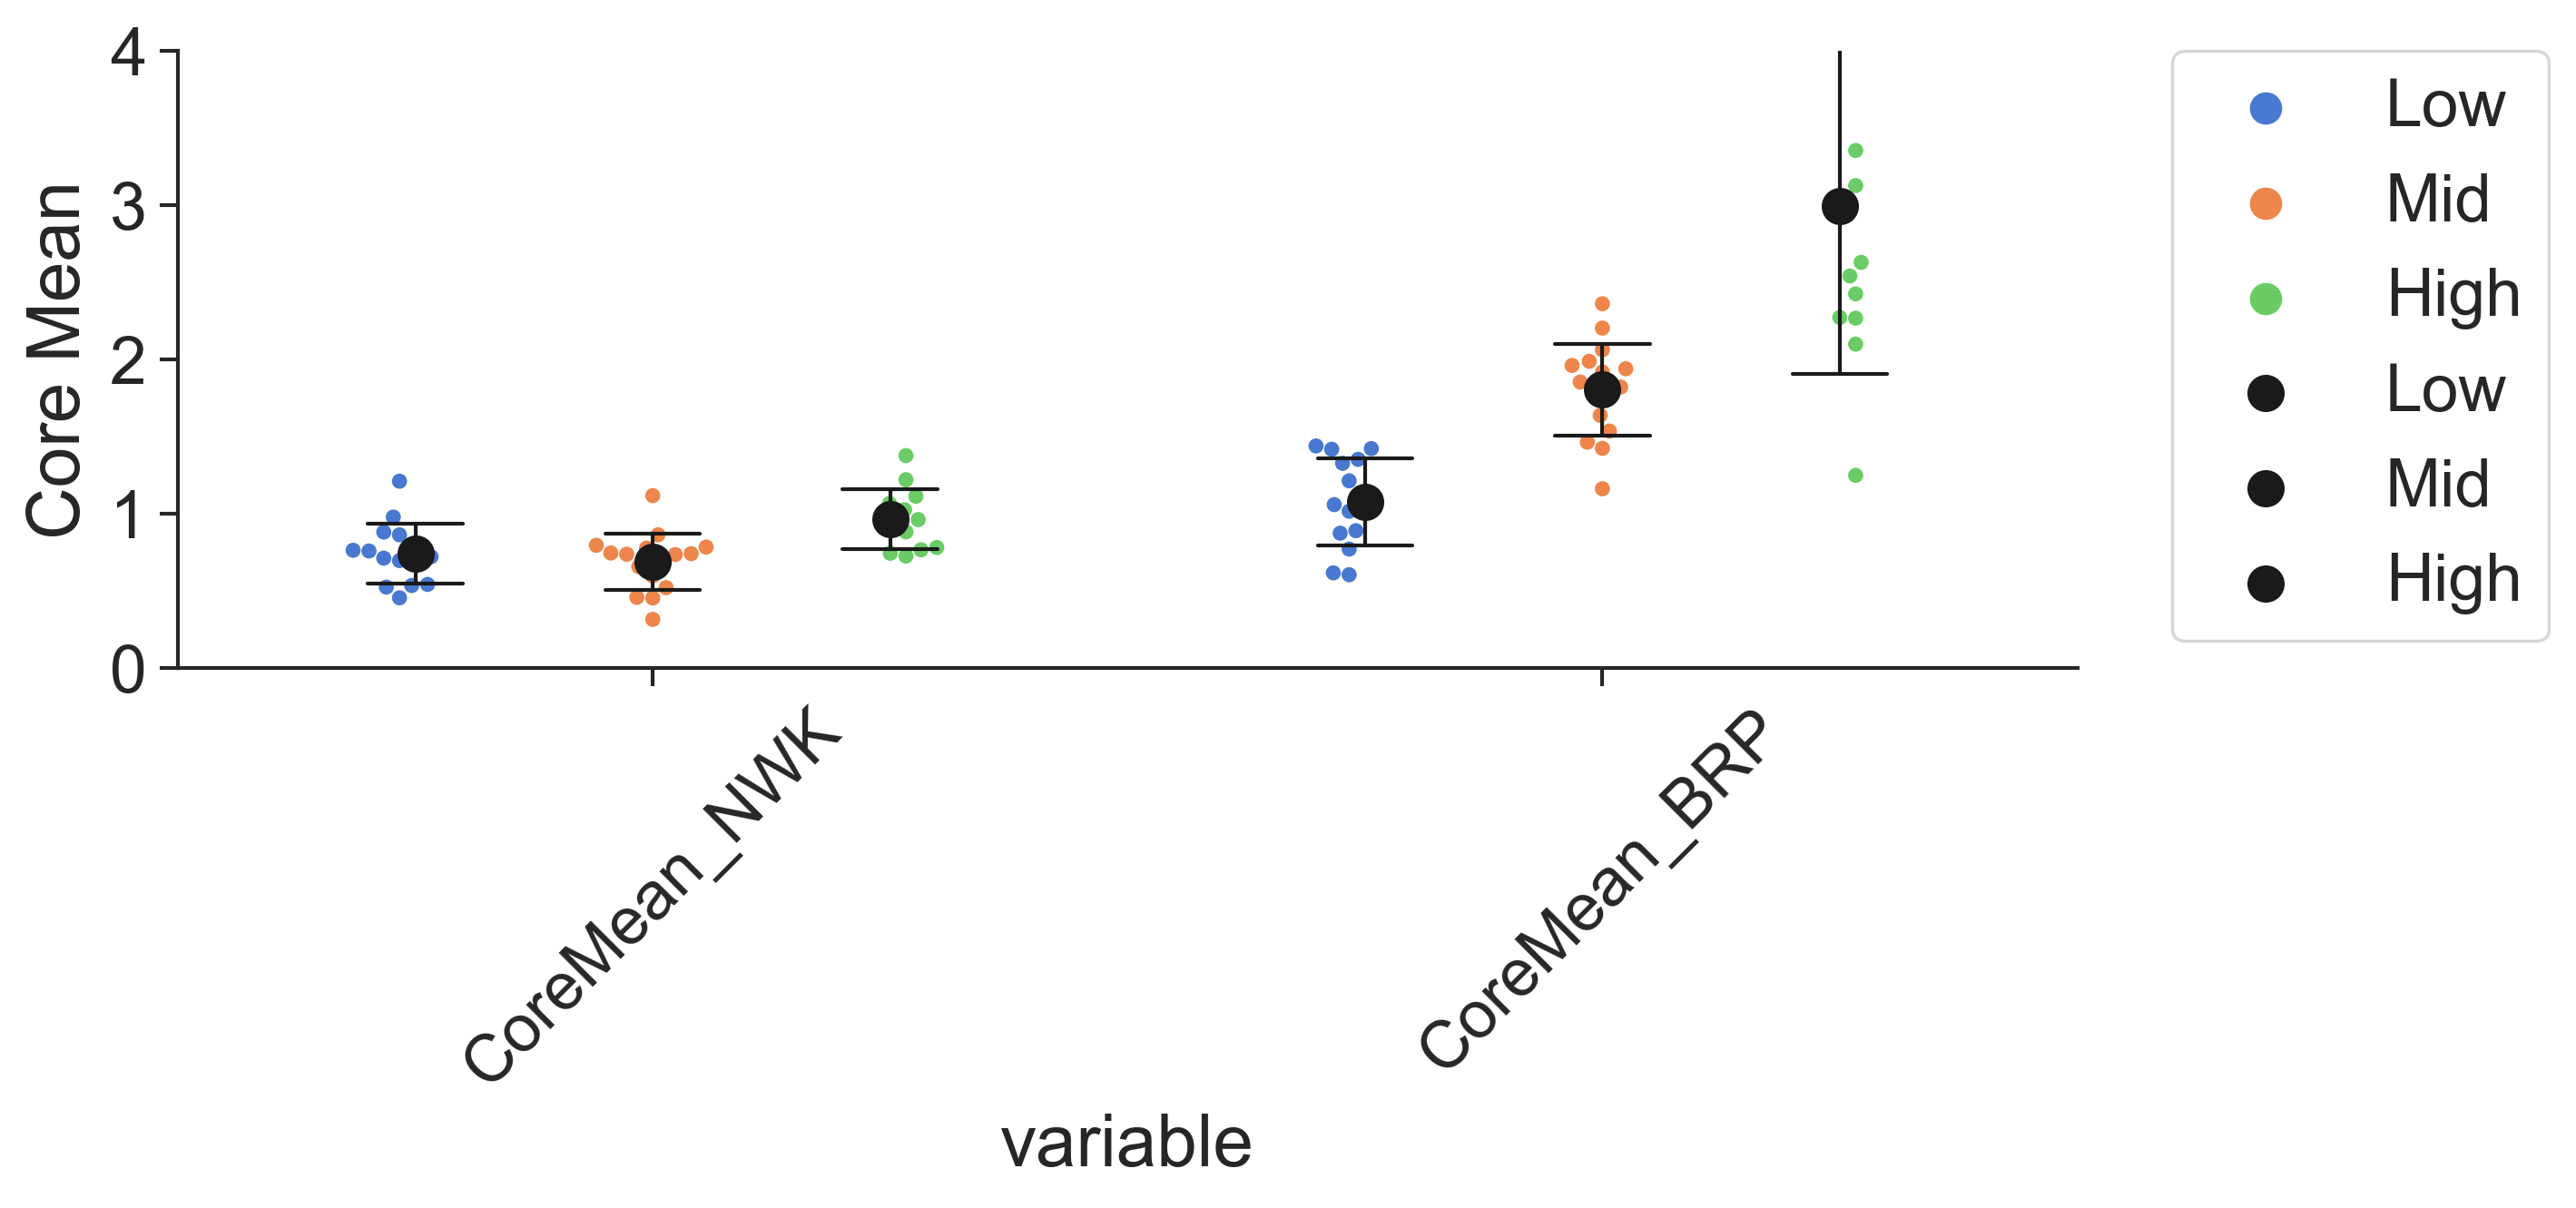

In [41]:
FIG = "Fig 4C_CoreMeanBinned"
# Make figure with binned AZid meshes
plt.figure(figsize=(9,3))

# Subset Mesh Mean data
cols = ["Experiment", "nmjid", "bins"] + [f"CoreMean_{chan}" for chan in data_order] + ["CoreMean_BRP"]
data = az1copy.loc[:, cols]

# Prep data for graphing
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index()
ExpMean = data.groupby(["Experiment", "bins"]).mean().reset_index()

ImgMean = ImgMean.melt(id_vars = ["Experiment", "nmjid", "bins"], value_name="Core Mean")
ExpMean = ExpMean.melt(id_vars = ["Experiment", "bins"], value_name="Core Mean")

# Plot data
sp = sns.swarmplot(data=ImgMean, x="variable", y="Core Mean", hue="bins", 
                   hue_order=["Low", "Mid", "High"], size=4, dodge=True, zorder=0)
sns.pointplot(data=ImgMean, x="variable", y="Core Mean",
              ci='sd', palette=['k'], scale=1.4,
              join=False, capsize=.1, errwidth=1, dodge=.5,
              hue="bins", hue_order=["Low", "Mid", "High"])
handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2
l = plt.legend(handles[0:], labels[0:], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.ylim((0,4))
plt.savefig(os.path.join(savepath, FIG + ".svg"))
None

In [42]:
# Stats for core mean
# Do a single anova or kw test for each channel
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index().drop(["Experiment", "nmjid"], axis=1)
ImgMean = ImgMean.pivot(columns = 'bins', values=ImgMean.columns.drop('bins'))
ImgMean.columns.names=[None, None]
#ImgMean = ImgMean.reset_index(drop=True)
chans=list(set([col[0] for col in ImgMean]))
analyses = {chan:agg.compareGroups(ImgMean[chan]) for chan in chans}

all_posthocs = pd.concat({key:chan['posthoc'] for key,chan in analyses.items()})
all_posthocs.to_csv(os.path.join(statspath, f"{FIG}-Posthoc_ByChannel.csv"))

Performed Kruskal-Wallis: test statistic = 29.869008068343618 p-value:3.266083683302155e-07
Performed Kruskal-Wallis: test statistic = 11.48791725992723 p-value:0.0032020673529980508


## Fig 4E Mesh Ratio by binned

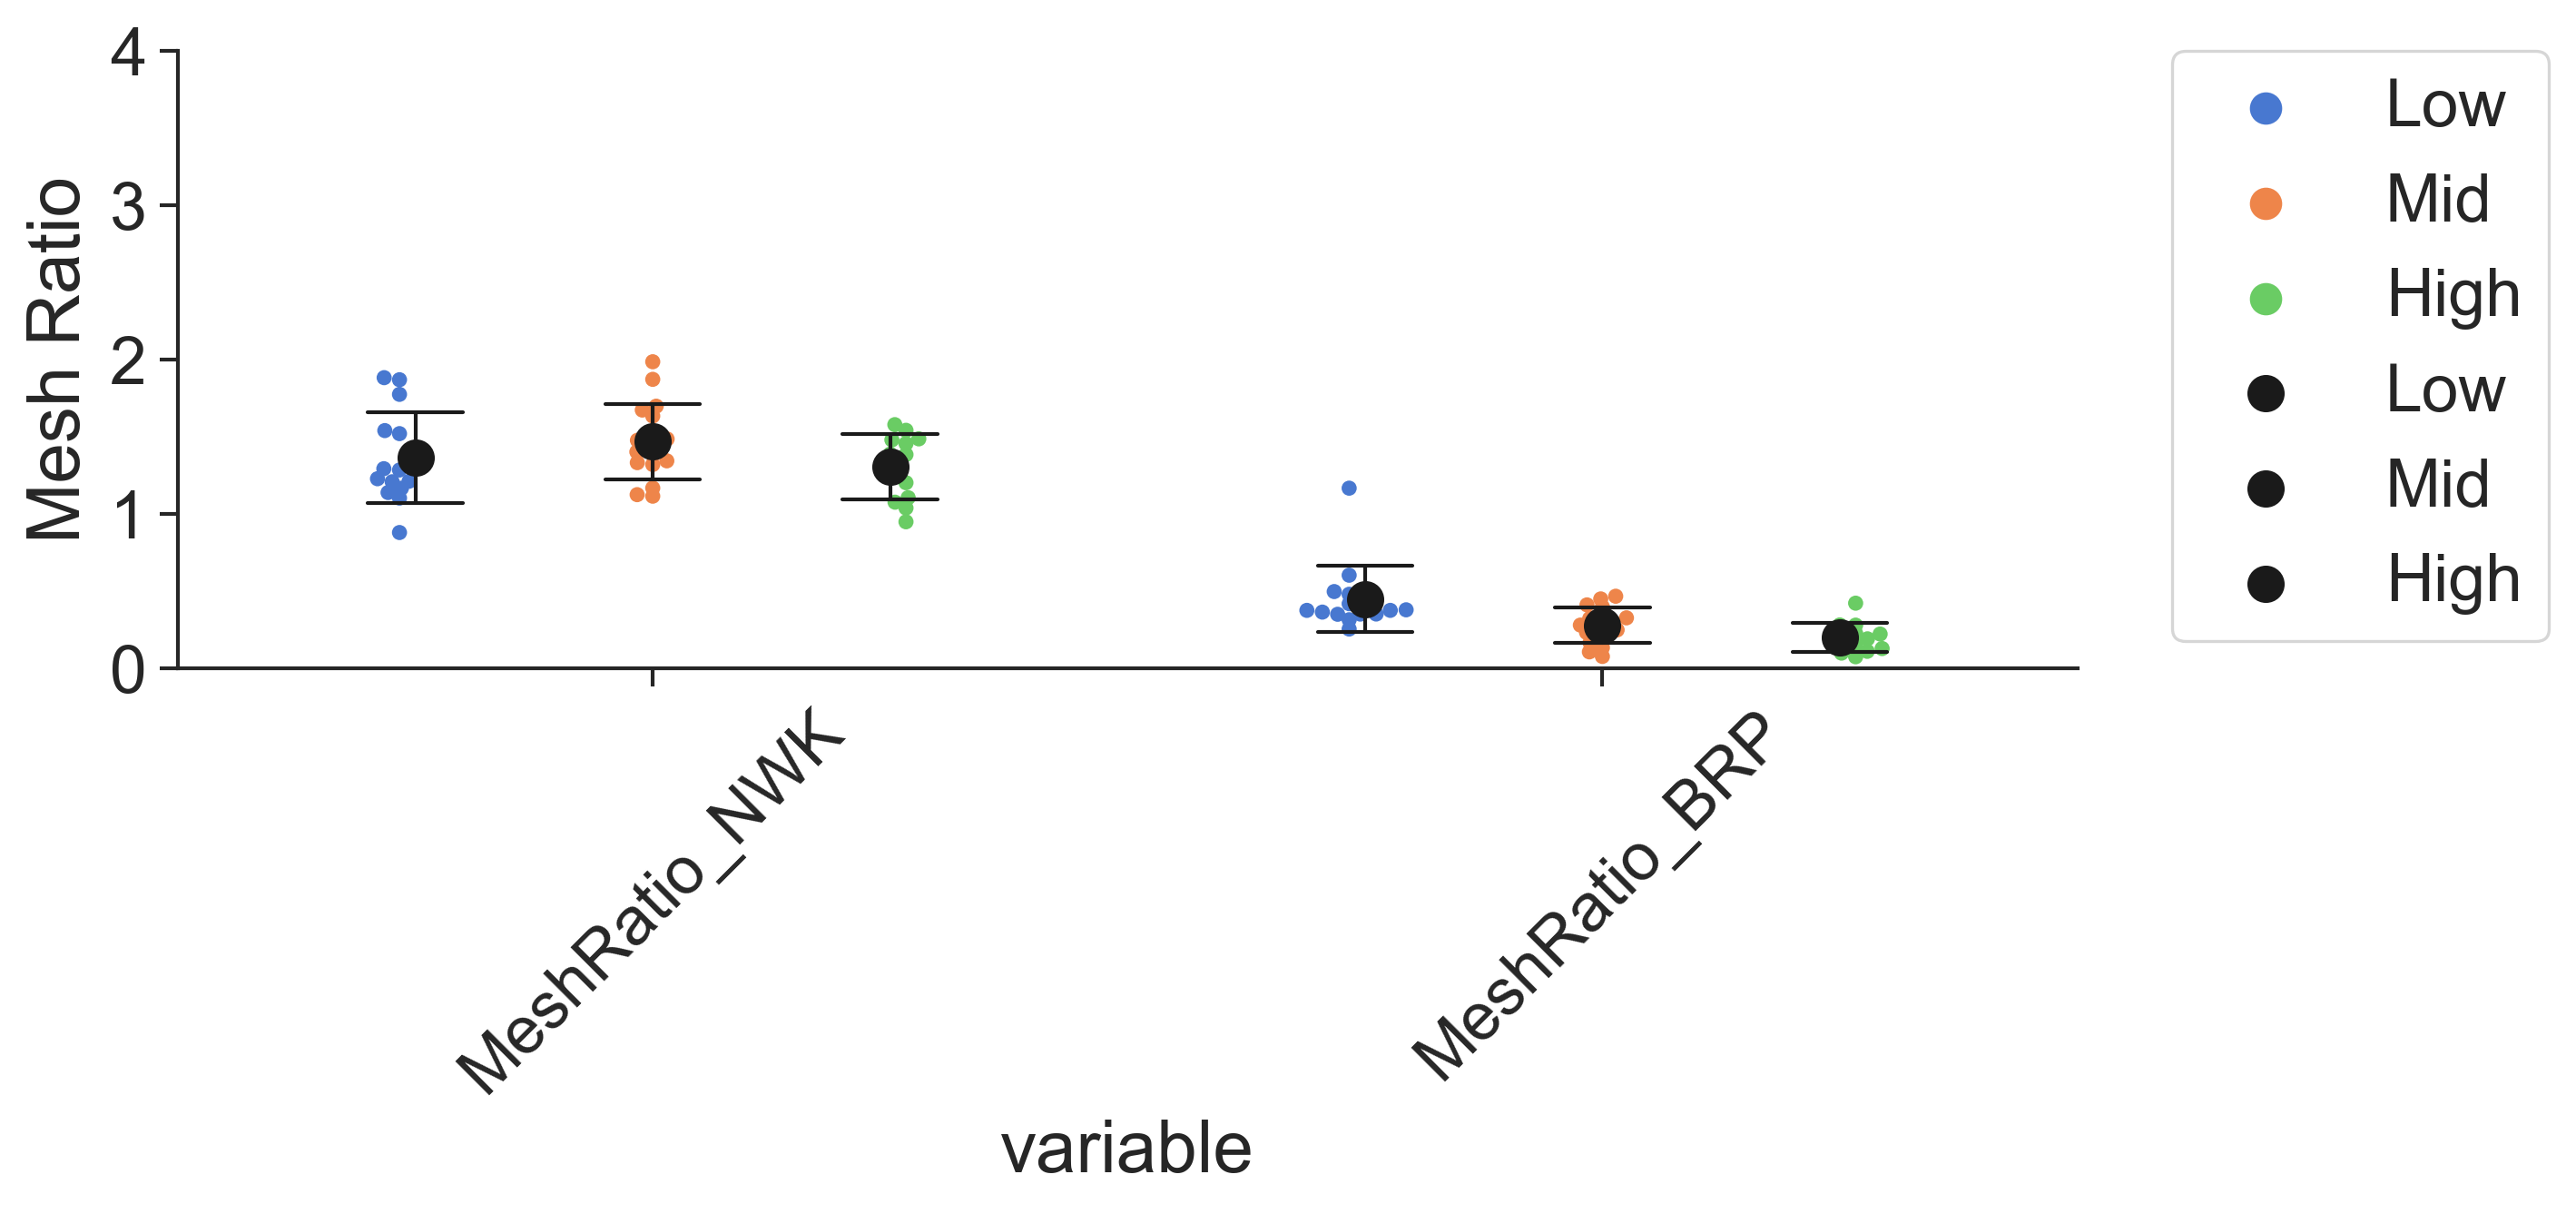

In [43]:
FIG = "Fig 4E-MeshRatioBinned"
# Make figure with binned AZid meshes
plt.figure(figsize=(9,3))

# Subset Mesh Ratio data
cols = ["Experiment", "nmjid", "bins"] + [f"MeshRatio_{chan}" for chan in data_order] + ["MeshRatio_BRP"]
data = az1copy.loc[:, cols]

# Prep data for graphing
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index()
ExpMean = data.groupby(["Experiment", "bins"]).mean().reset_index()

ImgMean = ImgMean.melt(id_vars = ["Experiment", "nmjid", "bins"], value_name="Mesh Ratio")
ExpMean = ExpMean.melt(id_vars = ["Experiment", "bins"], value_name="Mesh Ratio")

# Plot data
sp = sns.swarmplot(data=ImgMean, x="variable", y="Mesh Ratio", hue="bins", 
                   hue_order=["Low", "Mid", "High"], size=4, dodge=True, zorder=0)
sns.pointplot(data=ImgMean, x="variable", y="Mesh Ratio",
              ci='sd', palette=['k'], scale=1.4,
              join=False, capsize=.1, errwidth=1, dodge=.5,
              hue="bins", hue_order=["Low", "Mid", "High"])
handles, labels = sp.get_legend_handles_labels()
n = len(handles)//2
l = plt.legend(handles[0:], labels[0:], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.ylim((0,4))
plt.savefig(os.path.join(savepath, FIG + ".svg"))
None

In [ ]:
# Do a single anova or kw test for each channel
ImgMean = data.groupby(["Experiment", "nmjid", "bins"]).mean().reset_index().drop(["Experiment", "nmjid"], axis=1)
ImgMean = ImgMean.pivot(columns = 'bins', values=ImgMean.columns.drop('bins'))
ImgMean.columns.names=[None, None]
#ImgMean = ImgMean.reset_index(drop=True)
chans=list(set([col[0] for col in ImgMean]))
analyses = {chan:agg.compareGroups(ImgMean[chan]) for chan in chans}

all_posthocs = pd.concat({key:chan['posthoc'] for key,chan in analyses.items()})
all_posthocs.to_csv(os.path.join(statspath, f"{FIG}-Posthoc_ByChannel.csv"))

Performed Kruskal-Wallis: test statistic = 30.9474664646998 p-value:1.9047721947285682e-07
Performed Kruskal-Wallis: test statistic = 3.523851148851122 p-value:0.17171389738574155
Performed Kruskal-Wallis: test statistic = 6.968054773843505 p-value:0.03068358717911602
Performed Kruskal-Wallis: test statistic = 52.876710868450175 p-value:3.295855208767334e-12
Performed Kruskal-Wallis: test statistic = 25.003385988880837 p-value:3.7203493066871996e-06
Performed Kruskal-Wallis: test statistic = 0.6287900900674686 p-value:0.7302304972404077
